**PGR207 Deep Learning Exam**

Task 4: Optimizers

Candidate 2015

In [ ]:
# import

import os
import requests
import tarfile
import zipfile
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler

from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import VisionDataset
from torchvision.io import read_image
from torchvision.utils import make_grid
from torch.optim.lr_scheduler import StepLR
from PIL import Image

In [ ]:
# device
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class KvasirInstrument(VisionDataset):
  URL = "https://datasets.simula.no/downloads/kvasir-instrument.zip"
  BASE_FOLDER = "kvasir-instrument"
  IMAGES_FOLDER = "images"
  MASKS_FOLDER = "masks"

  def __init__(self, root, train=True, transform=None,target_transform=None, download=False):
    super().__init__(root, transform=transform)
    # Add target_transform for masks
    self.target_transform = target_transform
    if download:
      self.download()

    if not self._check_exists():
      raise RuntimeError('Dataset not found. Use download=True to download it.')

    data_file = "train.txt" if train else "test.txt"
    with open(os.path.join(root, self.BASE_FOLDER, data_file), "r") as f:
      self.images = [img.strip() for img in f.readlines()]

  def _check_exists(self):
    return os.path.exists(os.path.join(self.root, self.BASE_FOLDER, self.IMAGES_FOLDER))

  def download(self):
    if self._check_exists():
      return

    os.makedirs(self.root, exist_ok=True)

    r = requests.get(self.URL, allow_redirects=True)
    with open(os.path.join(self.root, "kvasir-instrument.zip"), 'wb') as f:
      f.write(r.content)

    with zipfile.ZipFile(os.path.join(self.root, "kvasir-instrument.zip"), 'r') as zip_ref:
      zip_ref.extractall(self.root)

    # extract images and masks from images.tar.gz and masks.tar.gz
    for tar_file in ["images.tar.gz", "masks.tar.gz"]:
        with tarfile.open(os.path.join(self.root, self.BASE_FOLDER, tar_file), 'r:gz') as tar_ref:
            tar_ref.extractall(os.path.join(self.root, self.BASE_FOLDER))

  def __getitem__(self, index):
    image_name = self.images[index]
    image_path = os.path.join(self.root, self.BASE_FOLDER, self.IMAGES_FOLDER, image_name + ".jpg")
    mask_path = os.path.join(self.root, self.BASE_FOLDER, self.MASKS_FOLDER, image_name + ".png")

    image = Image.open(image_path)
    mask = Image.open(mask_path)
    mask = mask.convert('L') # Convert mask to grayscale to ensure it's single channel
    # Ensure transforms are applied synchronously
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      mask = self.target_transform(mask)

    # After the transformations
    mask = mask.unsqueeze(0)  # Adding channel dimension

    return image, mask

  def __len__(self):
    return len(self.images)

In [ ]:
# Define the transform with resize, then transfer to tensor
image_transform = transforms.Compose([
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
])

mask_transform = transforms.Compose([
    transforms.Resize((576, 720)),
    transforms.ToTensor(),
    lambda x: (x > 0.5).float()
])

# Apply the transorm to the datasets
training_data = KvasirInstrument(root="data", train=True, download=True, transform=image_transform, target_transform=mask_transform)
test_data = KvasirInstrument(root="data", train=False, download=True, transform=image_transform, target_transform=mask_transform)
# Create the DataLoaders
train_loader = DataLoader(training_data, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Check the unique values in labels
all_labels = []

for _, labels in train_loader:
    all_labels.append(labels)

# Concatenate all labels into one tensor
all_labels_tensor = torch.cat(all_labels, dim=0)
unique_values = torch.unique(all_labels_tensor)

print(f"Unique values in labels: {unique_values}")
if not all(unique_values == torch.tensor([0, 1])):
    print("Warning: Labels contain values other than 0 and 1!")

Unique values in labels: tensor([0., 1.])


['/content/data/kvasir-instrument/images/ckd0agdp7000b3b5yml5zuxep.jpg', '/content/data/kvasir-instrument/images/ckd496imr000b3b5yie9cg7jd.jpg', '/content/data/kvasir-instrument/images/ckd48c2vt00023b5yye6a0fkm.jpg', '/content/data/kvasir-instrument/images/ckcxcriw1000g3b5ydfvxeenb.jpg', '/content/data/kvasir-instrument/images/ckcvwbrem000v3b5yvkhbh83i.jpg']
Image shape: (576, 720, 3)
Image shape: (576, 768, 3)
Image shape: (576, 720, 3)
Image shape: (1024, 1280, 3)
Image shape: (576, 720, 3)
Image shape: (1072, 1920, 3)


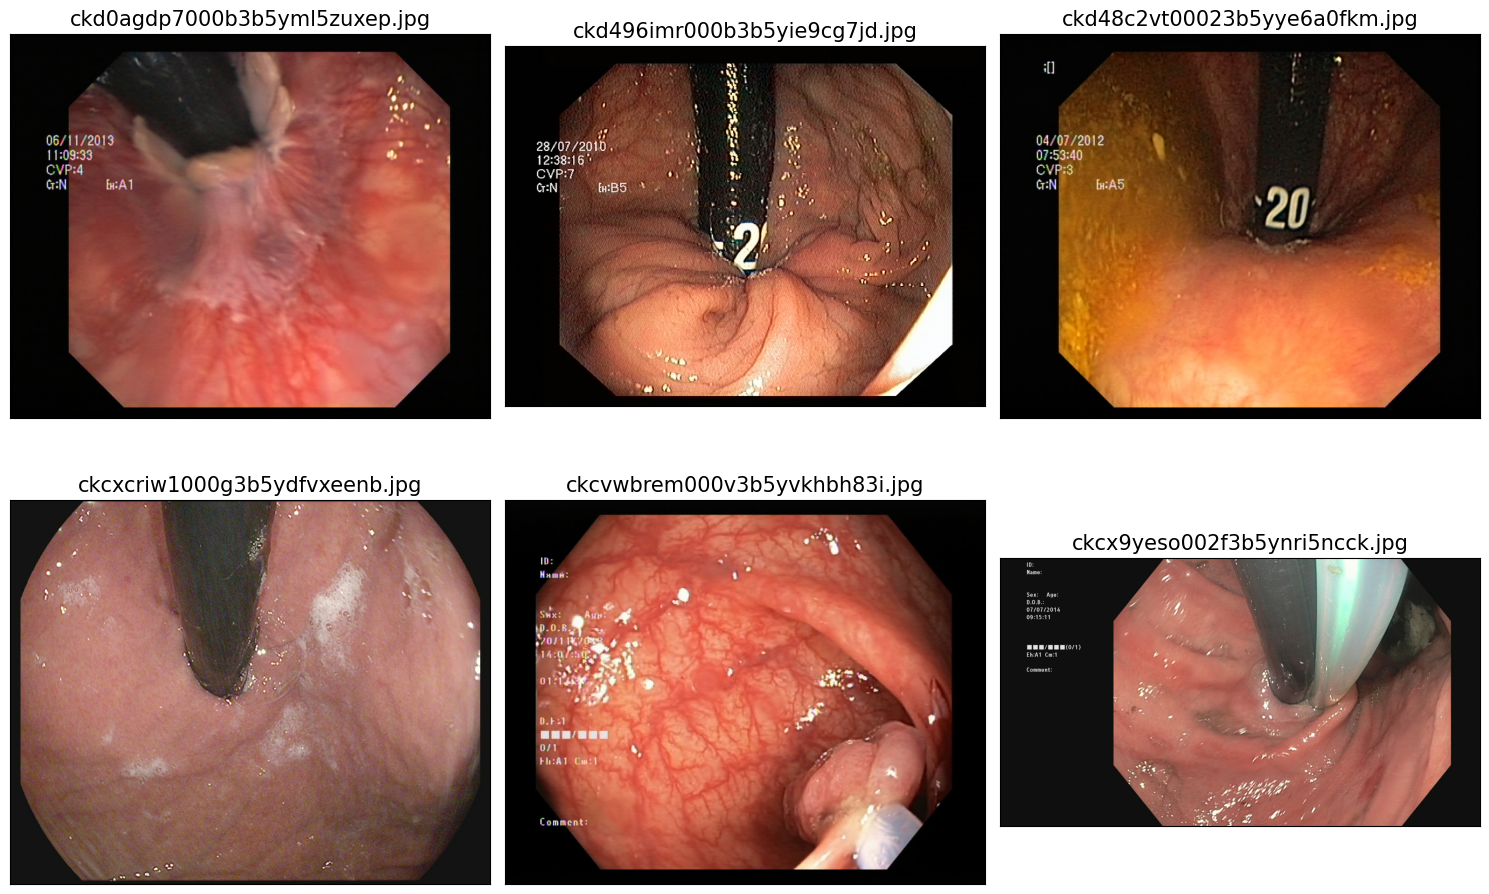

In [ ]:
# display images

images_list = []
for dirpath, dirnames, filenames in os.walk('/content/data/kvasir-instrument/images'):
  for filename in filenames:
    if filename.endswith('.jpg'):
      images_list.append(os.path.join(dirpath, filename))

print(images_list[:5])

n_rows = 2
n_cols = 3
total_images = n_rows * n_cols

fig = plt.figure(figsize=(15, 10))

for i, file in enumerate(images_list[:total_images]):
  img = Image.open(file)
  print('Image shape:', np.array(img).shape)

  ax = fig.add_subplot(n_rows, n_cols, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img)
  ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()

['/content/data/kvasir-instrument/masks/ckcx94kpn000v3b5yglqtusru.png', '/content/data/kvasir-instrument/masks/ckcvuxt6g000d3b5y3b9n1z8f.png', '/content/data/kvasir-instrument/masks/ckcudfm6w000q3b5ylbvgnqoq.png', '/content/data/kvasir-instrument/masks/ckd495l8u000a3b5yjzs1d5zg.png', '/content/data/kvasir-instrument/masks/ckcx41mch000i3b5y8opyl670.png']
Original Image shape: (576, 720, 3)
Single-channel mask shape: (576, 720)
0.0 1.0
Original Image shape: (1024, 1280, 3)
Single-channel mask shape: (1024, 1280)
0.0 1.0
Original Image shape: (530, 622, 3)
Single-channel mask shape: (530, 622)
0.0 1.0
Original Image shape: (576, 768, 3)
Single-channel mask shape: (576, 768)
0.0 1.0
Original Image shape: (576, 720, 3)
Single-channel mask shape: (576, 720)
0.0 1.0
Original Image shape: (576, 768, 3)
Single-channel mask shape: (576, 768)
0.0 1.0


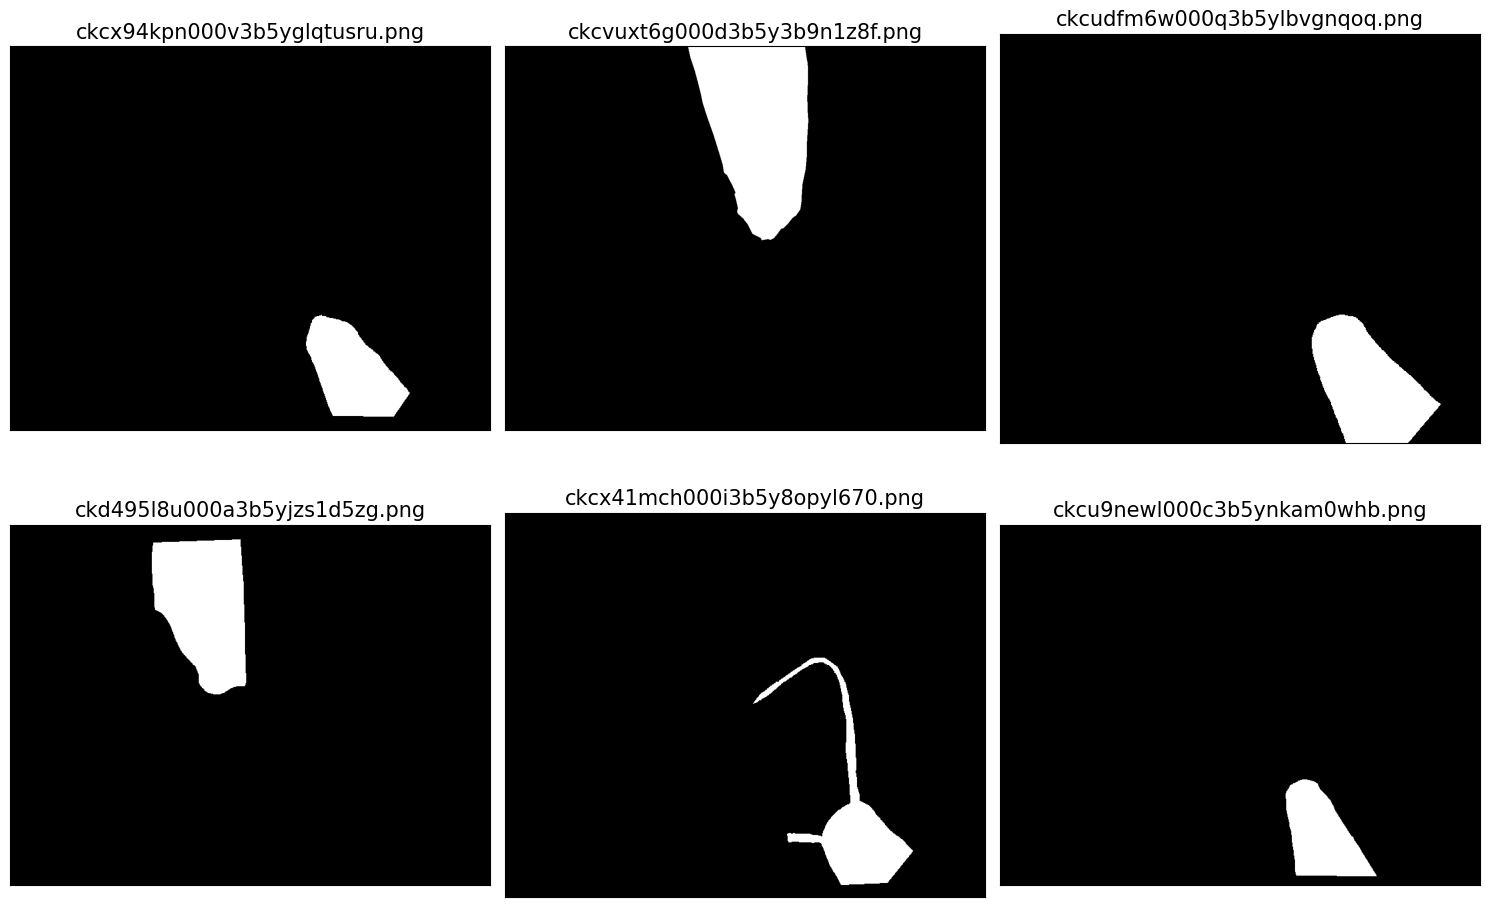

In [ ]:
# display masks

masks_list = []
for dirpath, dirnames, filenames in os.walk('/content/data/kvasir-instrument/masks'):
  for filename in filenames:
    if filename.endswith('.png'):
      masks_list.append(os.path.join(dirpath, filename))

print(masks_list[:5])

n_rows = 2
n_cols = 3
total_masks = n_rows * n_cols

fig = plt.figure(figsize=(15, 10))

for i, file in enumerate(masks_list[:total_masks]):
    # Load the masks
    mask = Image.open(file)
    print('Original Image shape:', np.array(mask).shape)
    mask = np.array(mask)

    # Convert 3-channel mask to 1-channel mask
    single_channel_mask = mask[:, :, 0]
    print('Single-channel mask shape:', single_channel_mask.shape)

    # check the mask pixel, ensure ground truth masks pixel within [0, 1]
    if single_channel_mask.max() > 1:
      single_channel_mask = single_channel_mask / 255.0
      print(single_channel_mask.min(), single_channel_mask.max())

    ax = fig.add_subplot(n_rows, n_cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.imshow(mask)
    ax.imshow(single_channel_mask, cmap='gray')  # Use a grayscale colormap for single-channel images
    ax.set_title(os.path.basename(file), size=15)

plt.tight_layout()
plt.show()

In [ ]:
# Define the U-Net model with ReLU activation
class UNet(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNet, self).__init__()
    self.device = device

    # Define the encoder
    self.enc1 = self.conv_block(in_channels, 64)
    self.enc2 = self.conv_block(64, 128)
    self.enc3 = self.conv_block(128, 256)
    self.enc4 = self.conv_block(256, 512)

    # Define the center
    self.center = self.conv_block(512, 1024)

    # Define the decoder
    self.dec4 = self.conv_block(1024 + 512, 512)
    self.dec3 = self.conv_block(512 + 256, 256)
    self.dec2 = self.conv_block(256 + 128, 128)
    self.dec1 = nn.Conv2d(128 + 64, out_channels, kernel_size=1)

    self.pool = nn.MaxPool2d(2, 2)

  def forward(self, x):
    enc1 = self.enc1(x)
    enc2 = self.enc2(self.pool(enc1))
    enc3 = self.enc3(self.pool(enc2))
    enc4 = self.enc4(self.pool(enc3))

    center = self.center(self.pool(enc4))

    dec4 = self.dec4(torch.cat([F.interpolate(center, scale_factor=2, mode='bilinear'), enc4], 1))
    dec3 = self.dec3(torch.cat([F.interpolate(dec4, scale_factor=2, mode='bilinear'), enc3], 1))
    dec2 = self.dec2(torch.cat([F.interpolate(dec3, scale_factor=2, mode='bilinear'), enc2], 1))
    dec1 = self.dec1(torch.cat([F.interpolate(dec2, scale_factor=2, mode='bilinear'), enc1], 1))

    return dec1

  def conv_block(self, in_channels, out_channels):
    return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
    nn.ReLU(inplace=True)
    )

model = UNet(3,1)

In [ ]:
model = UNet(3,1)

if torch.cuda.is_available():
    model.cuda()

In [ ]:
class EarlyStopping:
  def __init__(self, patience=7, verbose=False):
    self.patience = patience
    self.verbose = verbose
    #self.delta = delta
    self.counter = 0
    self.best_iou = float('-inf') # Initialize with negative infinity for maximizing
    self.early_stop = False
    self.path = "best_checkpoint.pt"

  def __call__(self, test_loss, test_accuracy, test_dsc_val, iou_score, model):
    #score_improvement = iou_score - self.best_iou
    if iou_score > self.best_iou:
      self.best_iou = iou_score
      self.save_checkpoint(test_loss, test_accuracy, test_dsc_val, iou_score, model)
      self.counter = 0
    else:
      self.counter += 1
      print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      if self.counter >= self.patience:
        self.early_stop = True

  def save_checkpoint(self, test_loss, test_accuracy, test_dsc_val, iou_score, model):
    '''Saves model when test IoU increases.'''
    if self.verbose:
      print(f'Test IoU increased {self.best_iou: .6f} --> {iou_score: .6f}. Saving model......')
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'loss': test_loss,
        'accuracy': test_accuracy,
        'DSC': test_dsc_val,
        'IoU_score': iou_score,
        }
    torch.save(checkpoint, self.path)

def train(dataloader, model, loss_fn, optimizer, device):
  model.train()  # Set the model to training mode
  running_loss = 0.0
  running_corrects = 0.0
  running_dice = 0.0
  running_iou = 0.0
  total_pixels = 0.0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y = y.squeeze(1) # Squeeze y to one dimension

    # Compute prediction, accuracy and loss
    pred = model(X)
    loss = loss_fn(pred, y.float()) # Do not extract the loss value before calculating the loss and doing backpropagation.

    # Backpropagation
    optimizer.zero_grad()
    loss.backward() # Backpropagation can be done here because loss is still a tensor
    optimizer.step()

    pred_binary = torch.sigmoid(pred) > 0.5
    corrects = (pred_binary.float() == y).float().sum().item()
    running_corrects += corrects
    total_pixels += y.numel()

    # Calculate batch Dice and Iou
    batch_dice = dice_coefficient(pred_binary, y).mean().item()
    batch_iou = iou_score(pred_binary, y).mean().item()

    # Update the running metrics
    running_loss += loss.item()
    running_dice += batch_dice
    running_iou += batch_iou

  # Compute average metrics for the epoch
  train_loss = running_loss / len(dataloader)
  train_accuracy = running_corrects / total_pixels
  train_dice = running_dice / len(dataloader)
  train_iou = running_iou / len(dataloader)

  return train_loss, train_accuracy, train_dice, train_iou

def test(dataloader, model, loss_fn, device):
  model.eval()
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss, correct = 0, 0
  running_corrects = 0.0
  total_pixels = 0.0
  running_dice = 0.0
  running_iou = 0.0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y = y.squeeze(1)

      pred = model(X)
      loss = loss_fn(pred, y.float())
      test_loss += loss_fn(pred, y.float()).item()  # Use .item() directly to obtain and accumulate the loss value for subsequent processing.
      pred_binary = torch.sigmoid(pred) > 0.5

      # Verify shape, ensure y and pred_binary are in the same shape
      if y.shape != pred_binary.shape:
          print(f"Warning: Shape mismatch! y: {y.shape}, pred_binary: {pred_binary.shape}")
          # Output the class count if the shape is mismatched
          class_counts = [(y == i).sum().item() for i in [0, 1]]
          print(f"Class counts - 0: {class_counts[0]}, 1: {class_counts[1]}")

      corrects = (pred_binary.float() == y).float().sum().item()
      running_corrects += corrects
      total_pixels += y.numel()
      running_dice += dice_coefficient(pred_binary, y).mean().item()
      running_iou += iou_score(pred_binary, y).mean().item()

  test_loss /= num_batches
  correct /= size
  test_accuracy = running_corrects / total_pixels
  test_dice = running_dice / len(dataloader)
  test_iou = running_iou / len(dataloader)
  return test_loss, test_accuracy, test_dice, test_iou

#Calculate Dice Coefficient
def dice_coefficient(pred, target):
  smooth = 1
  pred_flat = pred.view(-1)
  target_flat = target.view(-1)
  intersection = (pred_flat * target_flat).sum()
  return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

#Calculate Dice Loss
def dice_loss(pred, target):
  return 1 - dice_coefficient(pred, target)

#Calculate Mean Intersection over Union (IoU)
def iou_score(pred, target):
  # Convert boolean or float tensors to byte tensors
  if pred.dtype == torch.float32:
    pred = pred.bool()
  if target.dtype == torch.float32:
      target = target.bool()

  intersection = (pred & target).float().sum((1,2))
  union = (pred | target).sum((1,2))
  iou = (intersection.float() + 1) / (union.float() + 1) # Convert back to float for division
  return iou.mean()

# Ref.: https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/binary_segmentation_intro.ipynb
def visualize_comparisons(images, ground_truths, predictions_dict, device):
  """Visualize a batch of samples with their ground truth and prediction."""
  batch_size = images.size(0)
  #fig, axs = plt.subplots(batch_size, 3, figsize=(15, 15))
  #num_predictions = len(predictions)
  #fig, axs = plt.subplots(batch_size, 2 + num_predictions, figsize=((2 + num_predictions) * 5, batch_size * 5))
  fig, axs = plt.subplots(batch_size, 3 + len(predictions_dict), figsize=(5*(3+len(predictions_dict)), 5*batch_size))
  for i in range(batch_size):
    # Show image
    axs[i, 0].imshow(images[i].detach().to("cpu").permute(1, 2, 0).numpy())
    axs[i, 0].set_title('Image')
    axs[i,0].axis('off')
    # Show ground truth
    axs[i, 1].imshow(ground_truths[i].detach().to("cpu").numpy().squeeze(), cmap='gray')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')
    # Show each activation function's prediction
    for j, (prediction) in enumerate(predictions_dict):
      axs[i, j+2].imshow(prediction[i][0].detach().to("cpu").numpy().squeeze(), cmap='gray')
      axs[i, j+2].set_title(f'Prediction')
      axs[i, j+2].axis('off')

  plt.tight_layout()
  plt.show()

RAdam Optimizer

Test IoU increased  0.671250 -->  0.671250. Saving model......
Epoch 1 => Training Loss: 0.5089 - Training Accuracy: 77.85% - Test Loss: 0.3333 - Test Accuracy: 90.68% - Training DSC: 0.0561 - Test DSC: 0.0000 - Training IoU: 0.4532 - Test IoU: 0.6712
EarlyStopping counter: 1 out of 5
Epoch 2 => Training Loss: 0.2723 - Training Accuracy: 89.95% - Test Loss: 0.1771 - Test Accuracy: 90.68% - Training DSC: 0.0000 - Test DSC: 0.0000 - Training IoU: 0.6690 - Test IoU: 0.6712
Test IoU increased  0.802918 -->  0.802918. Saving model......
Epoch 3 => Training Loss: 0.1637 - Training Accuracy: 92.15% - Test Loss: 0.1114 - Test Accuracy: 96.08% - Training DSC: 0.3217 - Test DSC: 0.7541 - Training IoU: 0.7086 - Test IoU: 0.8029
EarlyStopping counter: 1 out of 5
Epoch 4 => Training Loss: 0.1455 - Training Accuracy: 94.29% - Test Loss: 0.1318 - Test Accuracy: 95.39% - Training DSC: 0.6493 - Test DSC: 0.6490 - Training IoU: 0.7680 - Test IoU: 0.7873
Test IoU increased  0.815983 -->  0.815983. Saving

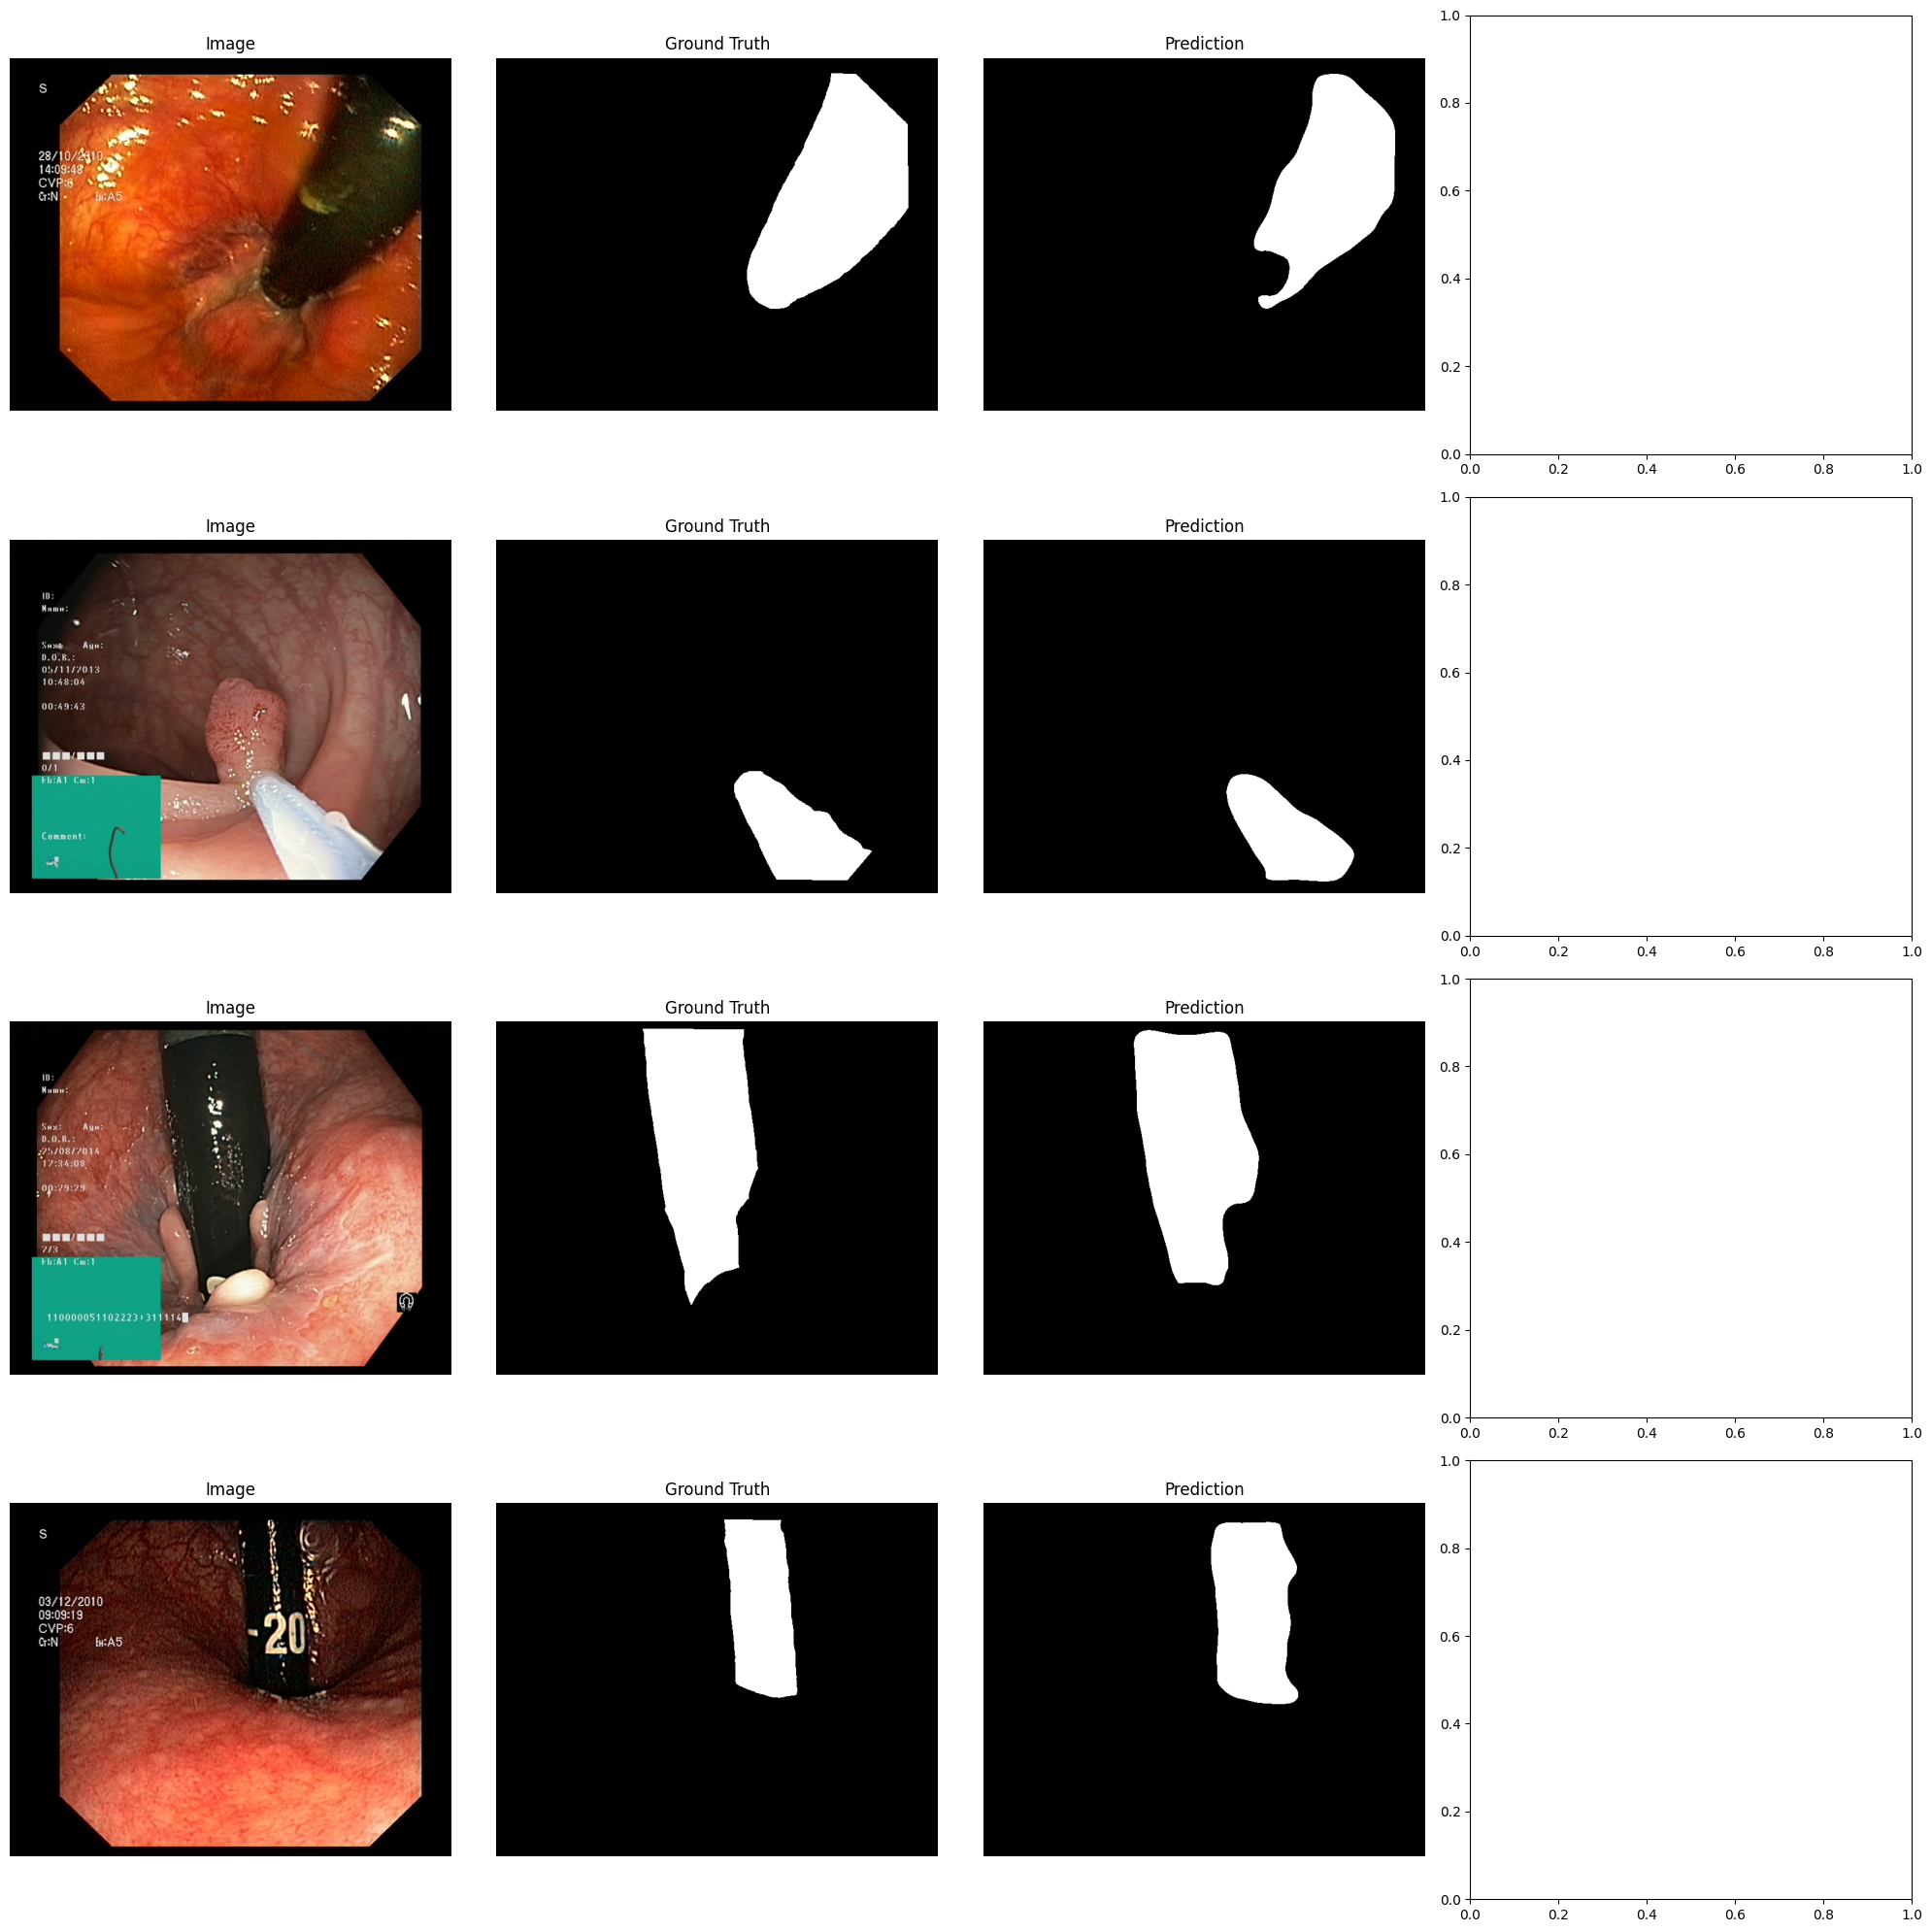


Best Results:
Best Loss       | 0.0630    
Best Accuracy   | 97.65%    
Best DSC        | 0.8590    
Best IoU        | 0.8754    


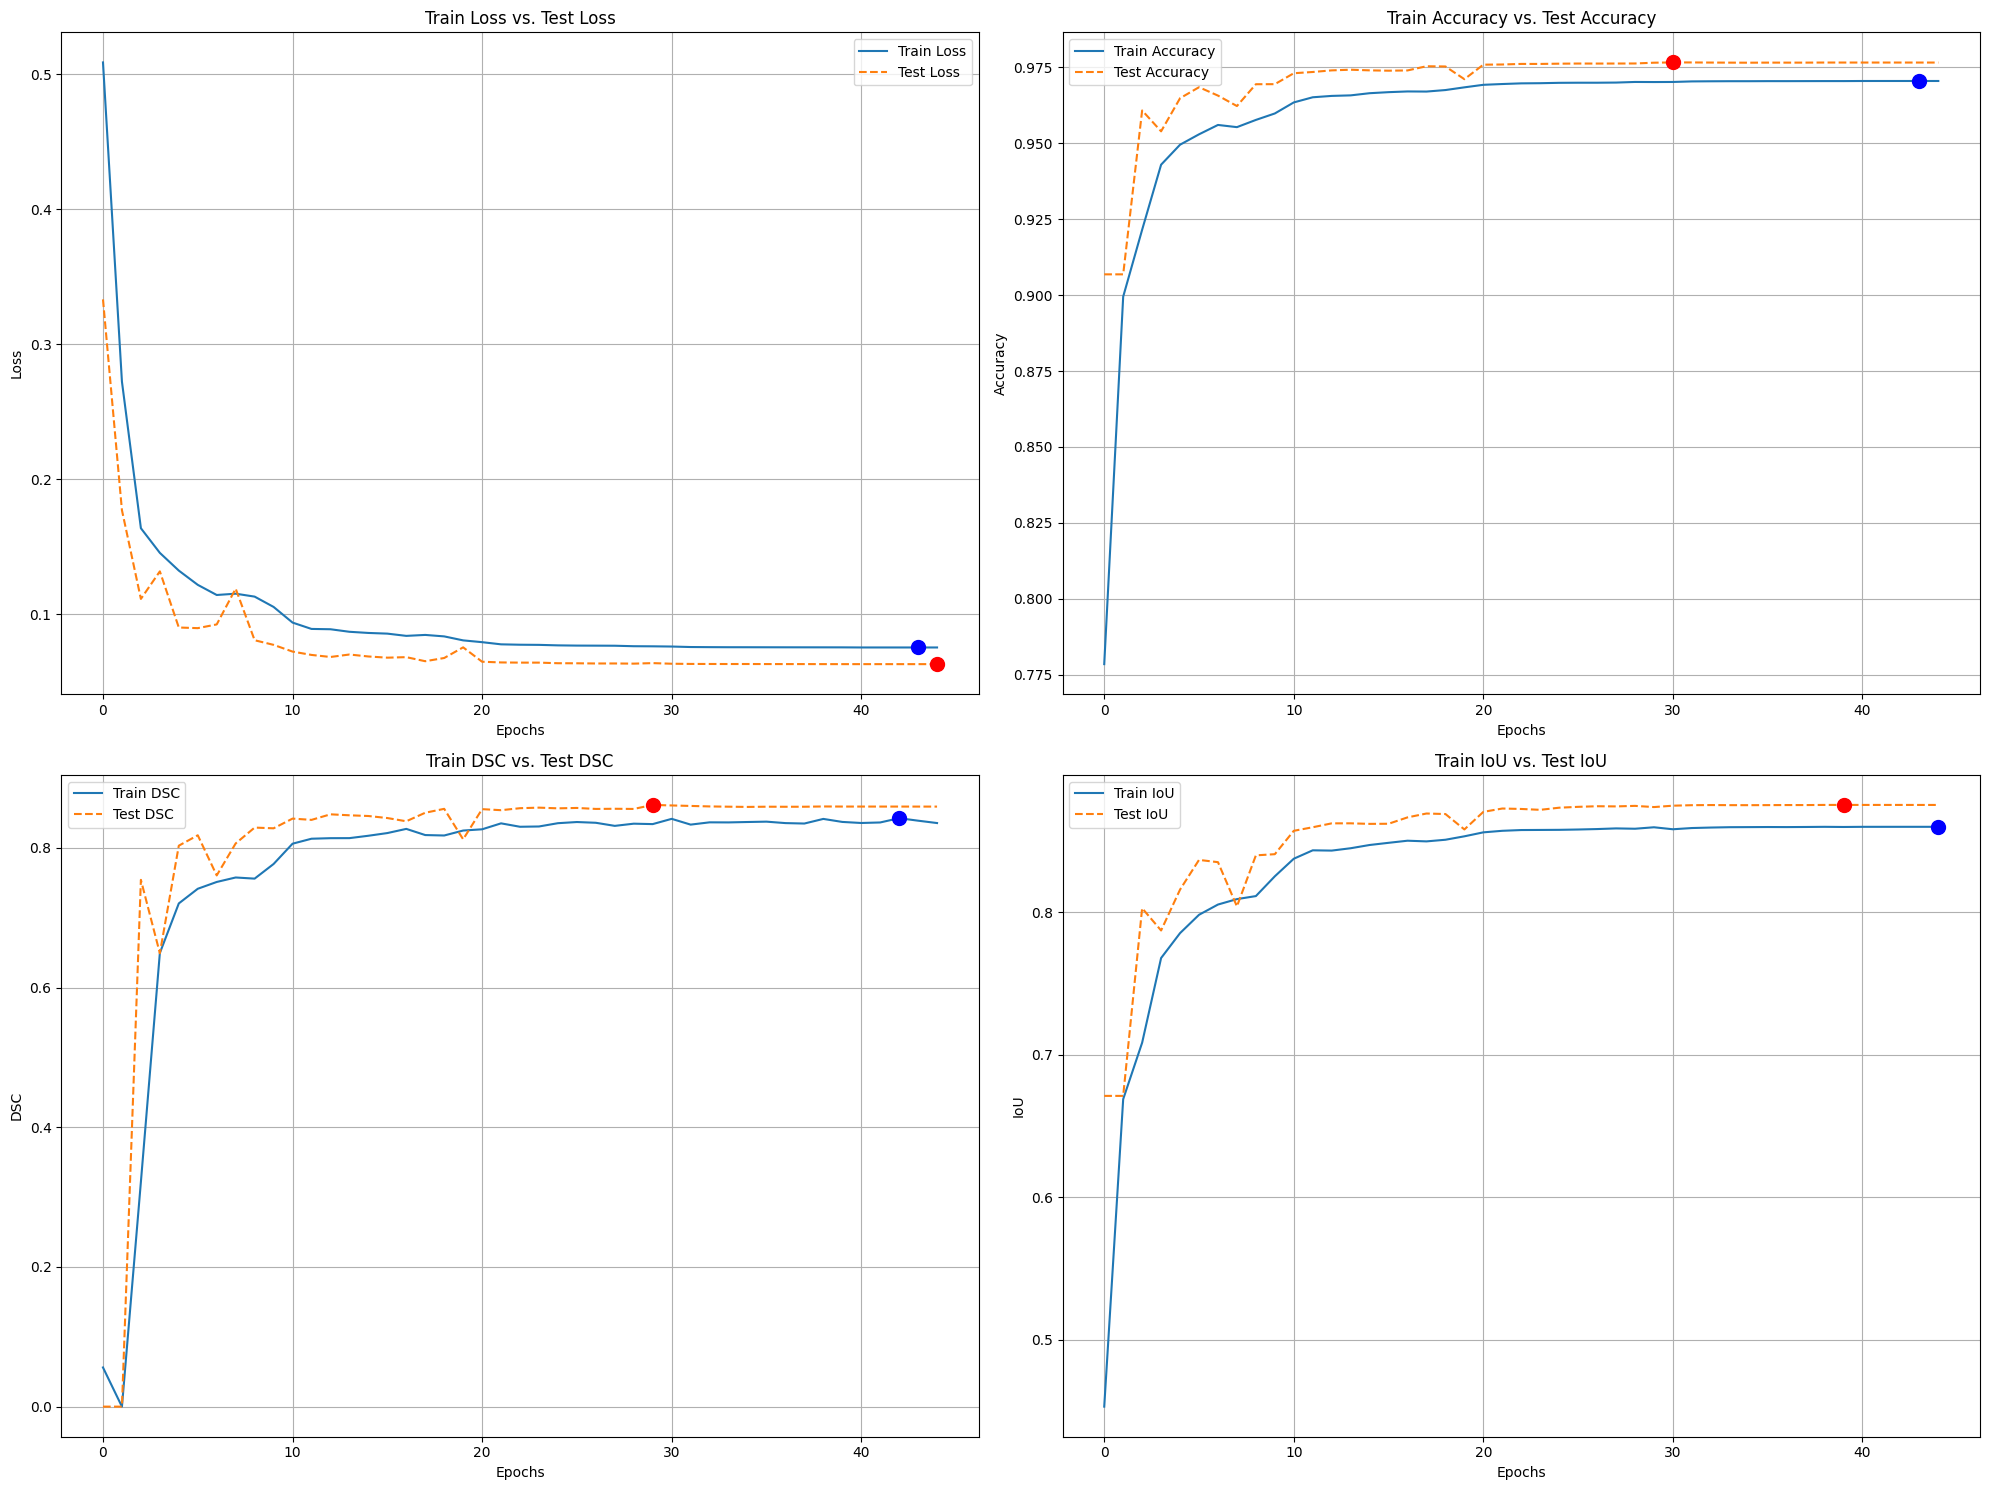

In [ ]:
# Hyperparameters
input_size = (576, 720)
out_channels = 1
batch_size = 4
best_loss = float('inf')
best_dsc = 0.0
best_iou = 0.0
best_accuracy = 0.0
visualized = False
epoch = 0

results = {}
best_results = {}

criterion = torch.nn.BCEWithLogitsLoss()
# use Learning-rate scheduler
optimizer = optim.RAdam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Initilize the train and test storage list
train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
train_dsc_history = []
test_dsc_history = []
train_iou_history = []
test_iou_history = []
test_loss_history = []

while not early_stopping.early_stop:
  # use different learning rates to train the model
  train_loss, train_accuracy, train_dsc_val, train_iou_val = train(train_loader, model, criterion, optimizer, device)
  test_loss, test_accuracy, test_dsc_val, test_iou_val = test(test_loader, model, criterion, device)

  # Append to the lists
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  train_accuracy_history.append(train_accuracy)
  test_accuracy_history.append(test_accuracy)
  train_dsc_history.append(train_dsc_val)
  test_dsc_history.append(test_dsc_val)
  train_iou_history.append(train_iou_val)
  test_iou_history.append(test_iou_val)

  early_stopping(test_loss, test_accuracy, test_dsc_val, test_iou_val, model)
  if early_stopping.early_stop:
    print('Early stopping')
    break
  scheduler.step()
  epoch += 1

  print(f"Epoch {epoch} => "
        f"Training Loss: {train_loss:.4f} - "
        f"Training Accuracy: {train_accuracy*100:.2f}% - "
        f"Test Loss: {test_loss:.4f} - "
        f"Test Accuracy: {test_accuracy*100:.2f}% - "
        f"Training DSC: {train_dsc_val:.4f} - "
        f"Test DSC: {test_dsc_val:.4f} - "
        f"Training IoU: {train_iou_val:.4f} - "
        f"Test IoU: {test_iou_val:.4f}")

results = {
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history,
    'train_accuracy_history': train_accuracy_history,
    'test_accuracy_history': test_accuracy_history,
    'train_dsc_history': train_dsc_history,
    'test_dsc_history': test_dsc_history,
    'train_iou_history': train_iou_history,
    'test_iou_history': test_iou_history
     }

# Evaluate the performance of the model on the test dataset
test_results = test(test_loader, model, criterion, device)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_dsc_val = test_results[2]
test_iou_val = test_results[3]  # Assuming IoU is the fourth value in your test results
if test_iou_val > best_iou:
  best_loss = test_results[0]  # Assuming loss is the first value in your test results
  best_accuracy = test_accuracy
  best_dsc = test_dsc_val
  best_iou = test_iou_val
  print(f"The best check point is => Best Loss: {best_loss:.4f}, Best Accuracy: {best_accuracy*100:.2f}%, Best DSC: {best_dsc:.4f}, Best IoU_score: {best_iou:.4f}")

  best_results = {
      'Best Loss': best_loss,
      'Best Accuracy': best_accuracy,
      'Best DSC': best_dsc,
      'Best IoU': best_iou
  }


  best_images_dict = {}
  best_ground_truths_dict = {}
  best_predictions_dict = {}


# Load the best checkpoint for the current activation function
best_checkpoint = torch.load("best_checkpoint.pt", map_location='cuda:0')
best_loss = best_checkpoint['loss']
best_accuracy = best_checkpoint['accuracy']
best_dsc = best_checkpoint['DSC']
best_iou = best_checkpoint['IoU_score']
# Load the best model
model.load_state_dict(best_checkpoint['model_state_dict'])

with torch.no_grad():
  best_images, best_ground_truths = next(iter(test_loader))
  best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
  outputs = model(best_images)
  predictions = torch.sigmoid(outputs) > 0.5

  # Store the results for each activation function
  best_images_dict = best_images
  best_ground_truths_dict = best_ground_truths
  best_predictions_dict = predictions

# Now, create a list or dictionary of predictions to pass to the visualization
predictions_list = [best_predictions_dict]
# Call the visualization function
visualize_comparisons(best_images, best_ground_truths, predictions_list, device=device)

# Print the best results
print('\nBest Results:')

for key, value in best_results.items():
    if key == 'Best Accuracy':
        print("{:<15} | {:<10.2%}".format(key, value))
    else:
        print("{:<15} | {:<10.4f}".format(key, value))

# Visualization
plt.figure(figsize=(20, 15))

# Train Loss vs. Test Loss
plt.subplot(2,2,1)
for key, data in results.items():
    if 'test_loss_history' in key:
        # Plot test loss with dashed line
        plt.plot(data, '--', label=f'Test Loss')
        best_test_loss_idx = np.argmin(data)
        best_test_loss = data[best_test_loss_idx]
        plt.scatter(best_test_loss_idx, best_test_loss, color='red', s=100, zorder=5)
    elif 'train_loss_history' in key:
        # Plot train loss
        plt.plot(data, label=f'Train Loss')
        best_train_loss_idx = np.argmin(data)
        best_train_loss = data[best_train_loss_idx]
        plt.scatter(best_train_loss_idx, best_train_loss, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.grid()

# Train Accuracy vs. Test Accuracy
plt.subplot(2,2,2)
for key, data in results.items():
    if 'test_accuracy_history' in key:
        # Plot test accuracy with dashed line
        plt.plot(data, '--', label=f'Test Accuracy')
        best_test_acc_idx = np.argmax(data)
        best_test_acc = data[best_test_acc_idx]
        plt.scatter(best_test_acc_idx, best_test_acc, color='red', s=100, zorder=5)
    elif 'train_accuracy_history' in key:
        # Plot train accuracy
        plt.plot(data, label=f'Train Accuracy')
        best_train_acc_idx = np.argmax(data)
        best_train_acc = data[best_train_acc_idx]
        plt.scatter(best_train_acc_idx, best_train_acc, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Test Accuracy')
plt.legend()
plt.grid()

# Train DSC vs. Test DSC
plt.subplot(2,2,3)
for key, data in results.items():
    if 'test_dsc_history' in key:
        # Plot test DSC with dashed line
        plt.plot(data, '--', label=f'Test DSC')
        best_test_dsc_idx = np.argmax(data)
        best_test_dsc = data[best_test_dsc_idx]
        plt.scatter(best_test_dsc_idx, best_test_dsc, color='red', s=100, zorder=5)
    elif 'train_dsc_history' in key:
        # Plot train DSC
        plt.plot(data, label=f'Train DSC')
        best_train_dsc_idx = np.argmax(data)
        best_train_dsc = data[best_train_dsc_idx]
        plt.scatter(best_train_dsc_idx, best_train_dsc, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('DSC')
plt.title('Train DSC vs. Test DSC')
plt.legend()
plt.grid()

# Train IoU vs. Test IoU
plt.subplot(2,2,4)
for key, data in results.items():
    if 'test_iou_history' in key:
        # Plot test IoU with dashed line
        plt.plot(data, '--', label=f'Test IoU')
        best_test_iou_idx = np.argmax(data)
        best_test_iou = data[best_test_iou_idx]
        plt.scatter(best_test_iou_idx, best_test_iou, color='red', s=100, zorder=5)
    elif 'train_iou_history' in key:
        # Plot train IoU
        plt.plot(data, label=f'Train IoU')
        best_train_iou_idx = np.argmax(data)
        best_train_iou = data[best_train_iou_idx]
        plt.scatter(best_train_iou_idx, best_train_iou, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Train IoU vs. Test IoU')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Adam Optimizer

Test IoU increased  0.671250 -->  0.671250. Saving model......
Epoch 1 => Training Loss: 0.3040 - Training Accuracy: 89.95% - Test Loss: 0.1598 - Test Accuracy: 90.68% - Training DSC: 0.0000 - Test DSC: 0.0000 - Training IoU: 0.6690 - Test IoU: 0.6712
Test IoU increased  0.732433 -->  0.732433. Saving model......
Epoch 2 => Training Loss: 0.1694 - Training Accuracy: 92.41% - Test Loss: 0.1553 - Test Accuracy: 93.19% - Training DSC: 0.4299 - Test DSC: 0.7193 - Training IoU: 0.7195 - Test IoU: 0.7324
Test IoU increased  0.775472 -->  0.775472. Saving model......
Epoch 3 => Training Loss: 0.1492 - Training Accuracy: 94.07% - Test Loss: 0.1292 - Test Accuracy: 95.20% - Training DSC: 0.6794 - Test DSC: 0.6517 - Training IoU: 0.7644 - Test IoU: 0.7755
Test IoU increased  0.799070 -->  0.799070. Saving model......
Epoch 4 => Training Loss: 0.1361 - Training Accuracy: 94.58% - Test Loss: 0.1159 - Test Accuracy: 96.11% - Training DSC: 0.6965 - Test DSC: 0.7433 - Training IoU: 0.7689 - Test IoU:

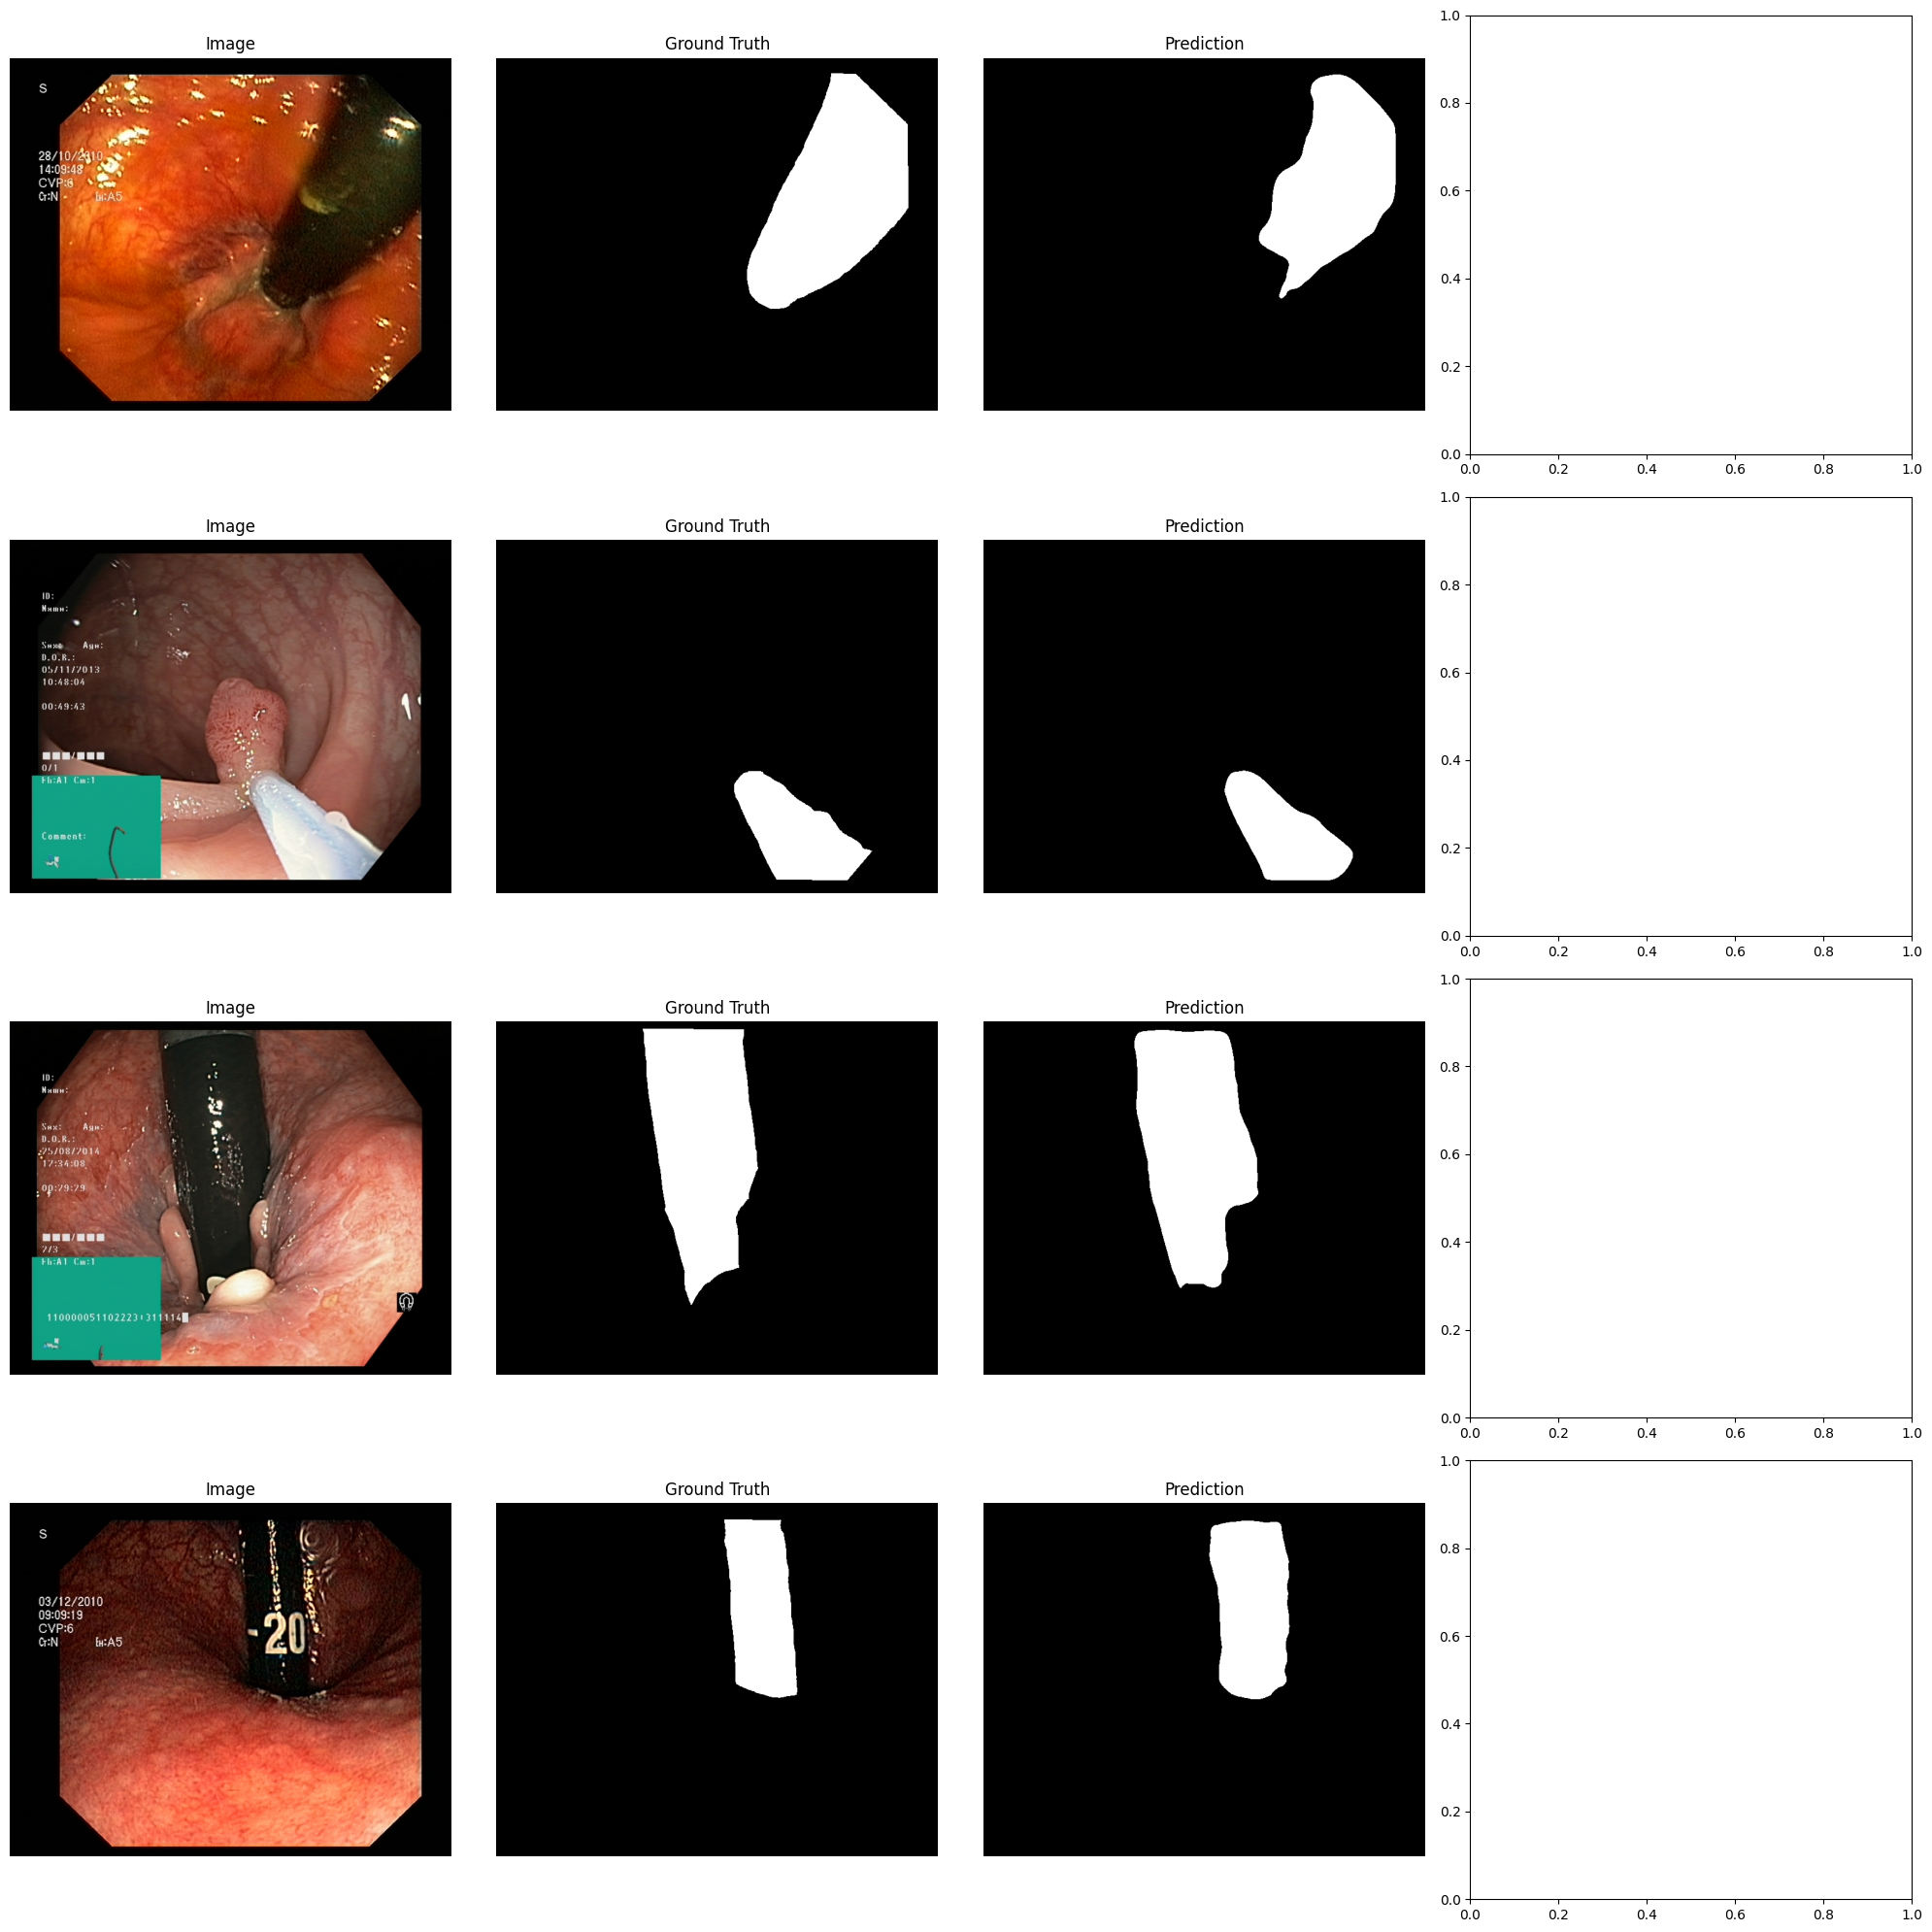


Best Results:
Best Loss       | 0.0610    
Best Accuracy   | 97.92%    
Best DSC        | 0.8774    
Best IoU        | 0.8861    


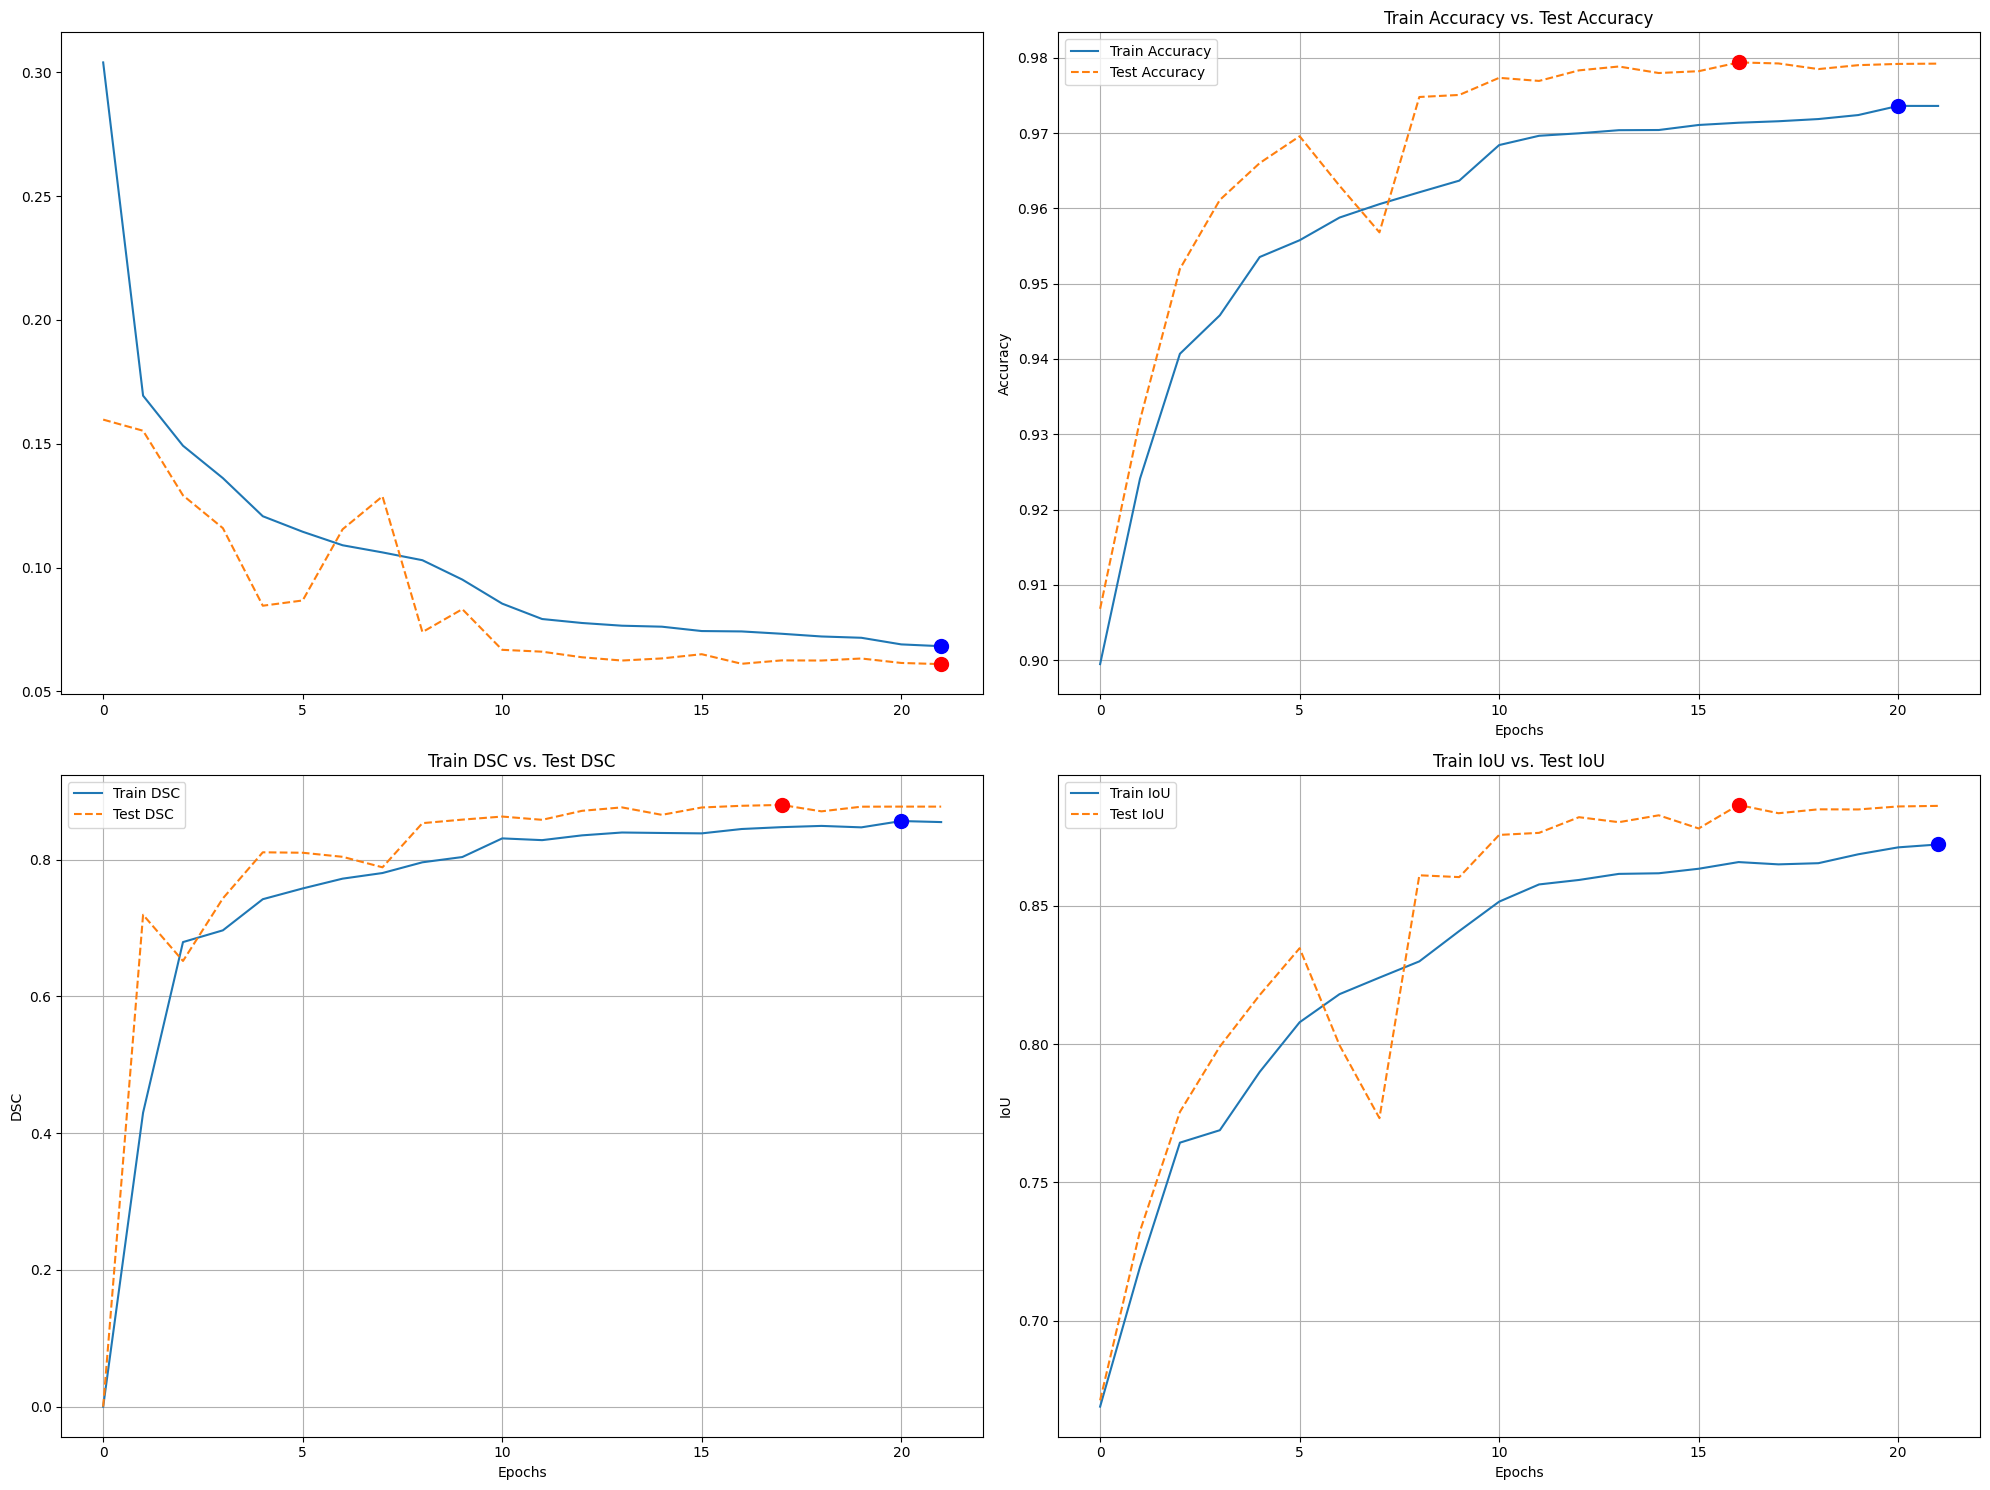

In [ ]:
# Hyperparameters
input_size = (576, 720)
out_channels = 1
batch_size = 4
best_loss = float('inf')
best_dsc = 0.0
best_iou = 0.0
best_accuracy = 0.0
visualized = False
epoch = 0

results = {}
best_results = {}

criterion = torch.nn.BCEWithLogitsLoss()
# use Learning-rate scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Initilize the train and test storage list
train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
train_dsc_history = []
test_dsc_history = []
train_iou_history = []
test_iou_history = []
test_loss_history = []

while not early_stopping.early_stop:
  # use different learning rates to train the model
  train_loss, train_accuracy, train_dsc_val, train_iou_val = train(train_loader, model, criterion, optimizer, device)
  test_loss, test_accuracy, test_dsc_val, test_iou_val = test(test_loader, model, criterion, device)

  # Append to the lists
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  train_accuracy_history.append(train_accuracy)
  test_accuracy_history.append(test_accuracy)
  train_dsc_history.append(train_dsc_val)
  test_dsc_history.append(test_dsc_val)
  train_iou_history.append(train_iou_val)
  test_iou_history.append(test_iou_val)

  early_stopping(test_loss, test_accuracy, test_dsc_val, test_iou_val, model)
  if early_stopping.early_stop:
    print('Early stopping')
    break
  scheduler.step()
  epoch += 1

  print(f"Epoch {epoch} => "
        f"Training Loss: {train_loss:.4f} - "
        f"Training Accuracy: {train_accuracy*100:.2f}% - "
        f"Test Loss: {test_loss:.4f} - "
        f"Test Accuracy: {test_accuracy*100:.2f}% - "
        f"Training DSC: {train_dsc_val:.4f} - "
        f"Test DSC: {test_dsc_val:.4f} - "
        f"Training IoU: {train_iou_val:.4f} - "
        f"Test IoU: {test_iou_val:.4f}")

results = {
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history,
    'train_accuracy_history': train_accuracy_history,
    'test_accuracy_history': test_accuracy_history,
    'train_dsc_history': train_dsc_history,
    'test_dsc_history': test_dsc_history,
    'train_iou_history': train_iou_history,
    'test_iou_history': test_iou_history
     }

# Evaluate the performance of the model on the test dataset
test_results = test(test_loader, model, criterion, device)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_dsc_val = test_results[2]
test_iou_val = test_results[3]  # Assuming IoU is the fourth value in your test results
if test_iou_val > best_iou:
  best_loss = test_results[0]  # Assuming loss is the first value in your test results
  best_accuracy = test_accuracy
  best_dsc = test_dsc_val
  best_iou = test_iou_val
  print(f"The best check point is => Best Loss: {best_loss:.4f}, Best Accuracy: {best_accuracy*100:.2f}%, Best DSC: {best_dsc:.4f}, Best IoU_score: {best_iou:.4f}")

  best_results = {
      'Best Loss': best_loss,
      'Best Accuracy': best_accuracy,
      'Best DSC': best_dsc,
      'Best IoU': best_iou
  }


  best_images_dict = {}
  best_ground_truths_dict = {}
  best_predictions_dict = {}


# Load the best checkpoint for the current activation function
best_checkpoint = torch.load("best_checkpoint.pt", map_location='cuda:0')
best_loss = best_checkpoint['loss']
best_accuracy = best_checkpoint['accuracy']
best_dsc = best_checkpoint['DSC']
best_iou = best_checkpoint['IoU_score']
# Load the best model
model.load_state_dict(best_checkpoint['model_state_dict'])

with torch.no_grad():
  best_images, best_ground_truths = next(iter(test_loader))
  best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
  outputs = model(best_images)
  predictions = torch.sigmoid(outputs) > 0.5

  # Store the results for each activation function
  best_images_dict = best_images
  best_ground_truths_dict = best_ground_truths
  best_predictions_dict = predictions


# Now, create a list or dictionary of predictions to pass to the visualization
predictions_list = [best_predictions_dict]
# Call the visualization function
visualize_comparisons(best_images, best_ground_truths, predictions_list, device=device)

# Print the best results in a table format
print('\nBest Results:')

for key, value in best_results.items():
    if key == 'Best Accuracy':
        print("{:<15} | {:<10.2%}".format(key, value))
    else:
        print("{:<15} | {:<10.4f}".format(key, value))

# Visualization
plt.figure(figsize=(20, 15))

# Train Loss vs. Test Loss
plt.subplot(2,2,1)
for key, data in results.items():
    if 'test_loss_history' in key:
        # Plot test loss with dashed line
        plt.plot(data, '--', label=f'Test Loss')
        best_test_loss_idx = np.argmin(data)
        best_test_loss = data[best_test_loss_idx]
        plt.scatter(best_test_loss_idx, best_test_loss, color='red', s=100, zorder=5)
    elif 'train_loss_history' in key:
        # Plot train loss
        plt.plot(data, label=f'Train Loss')
        best_train_loss_idx = np.argmin(data)
        best_train_loss = data[best_train_loss_idx]
        plt.scatter(best_train_loss_idx, best_train_loss, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.grid()

# Train Accuracy vs. Test Accuracy
plt.subplot(2,2,2)
for key, data in results.items():
    if 'test_accuracy_history' in key:
        # Plot test accuracy with dashed line
        plt.plot(data, '--', label=f'Test Accuracy')
        best_test_acc_idx = np.argmax(data)
        best_test_acc = data[best_test_acc_idx]
        plt.scatter(best_test_acc_idx, best_test_acc, color='red', s=100, zorder=5)
    elif 'train_accuracy_history' in key:
        # Plot train accuracy
        plt.plot(data, label=f'Train Accuracy')
        best_train_acc_idx = np.argmax(data)
        best_train_acc = data[best_train_acc_idx]
        plt.scatter(best_train_acc_idx, best_train_acc, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Test Accuracy')
plt.legend()
plt.grid()

# Train DSC vs. Test DSC
plt.subplot(2,2,3)
for key, data in results.items():
    if 'test_dsc_history' in key:
        # Plot test DSC with dashed line
        plt.plot(data, '--', label=f'Test DSC')
        best_test_dsc_idx = np.argmax(data)
        best_test_dsc = data[best_test_dsc_idx]
        plt.scatter(best_test_dsc_idx, best_test_dsc, color='red', s=100, zorder=5)
    elif 'train_dsc_history' in key:
        # Plot train DSC
        plt.plot(data, label=f'Train DSC')
        best_train_dsc_idx = np.argmax(data)
        best_train_dsc = data[best_train_dsc_idx]
        plt.scatter(best_train_dsc_idx, best_train_dsc, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('DSC')
plt.title('Train DSC vs. Test DSC')
plt.legend()
plt.grid()

# Train IoU vs. Test IoU
plt.subplot(2,2,4)
for key, data in results.items():
    if 'test_iou_history' in key:
        # Plot test IoU with dashed line
        plt.plot(data, '--', label=f'Test IoU')
        best_test_iou_idx = np.argmax(data)
        best_test_iou = data[best_test_iou_idx]
        plt.scatter(best_test_iou_idx, best_test_iou, color='red', s=100, zorder=5)
    elif 'train_iou_history' in key:
        # Plot train IoU
        plt.plot(data, label=f'Train IoU')
        best_train_iou_idx = np.argmax(data)
        best_train_iou = data[best_train_iou_idx]
        plt.scatter(best_train_iou_idx, best_train_iou, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Train IoU vs. Test IoU')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


RMSprop Optimizer

Test IoU increased  0.848124 -->  0.848124. Saving model......
Epoch 1 => Training Loss: 11.0180 - Training Accuracy: 94.17% - Test Loss: 0.0844 - Test Accuracy: 97.22% - Training DSC: 0.6165 - Test DSC: 0.8342 - Training IoU: 0.7731 - Test IoU: 0.8481
Test IoU increased  0.863785 -->  0.863785. Saving model......
Epoch 2 => Training Loss: 0.0997 - Training Accuracy: 96.25% - Test Loss: 0.0741 - Test Accuracy: 97.46% - Training DSC: 0.7974 - Test DSC: 0.8551 - Training IoU: 0.8293 - Test IoU: 0.8638
EarlyStopping counter: 1 out of 5
Epoch 3 => Training Loss: 0.0901 - Training Accuracy: 96.57% - Test Loss: 0.1095 - Test Accuracy: 95.99% - Training DSC: 0.8128 - Test DSC: 0.7116 - Training IoU: 0.8428 - Test IoU: 0.8140
Test IoU increased  0.886383 -->  0.886383. Saving model......
Epoch 4 => Training Loss: 0.0886 - Training Accuracy: 96.68% - Test Loss: 0.0639 - Test Accuracy: 97.86% - Training DSC: 0.8190 - Test DSC: 0.8756 - Training IoU: 0.8478 - Test IoU: 0.8864
Test IoU increased  

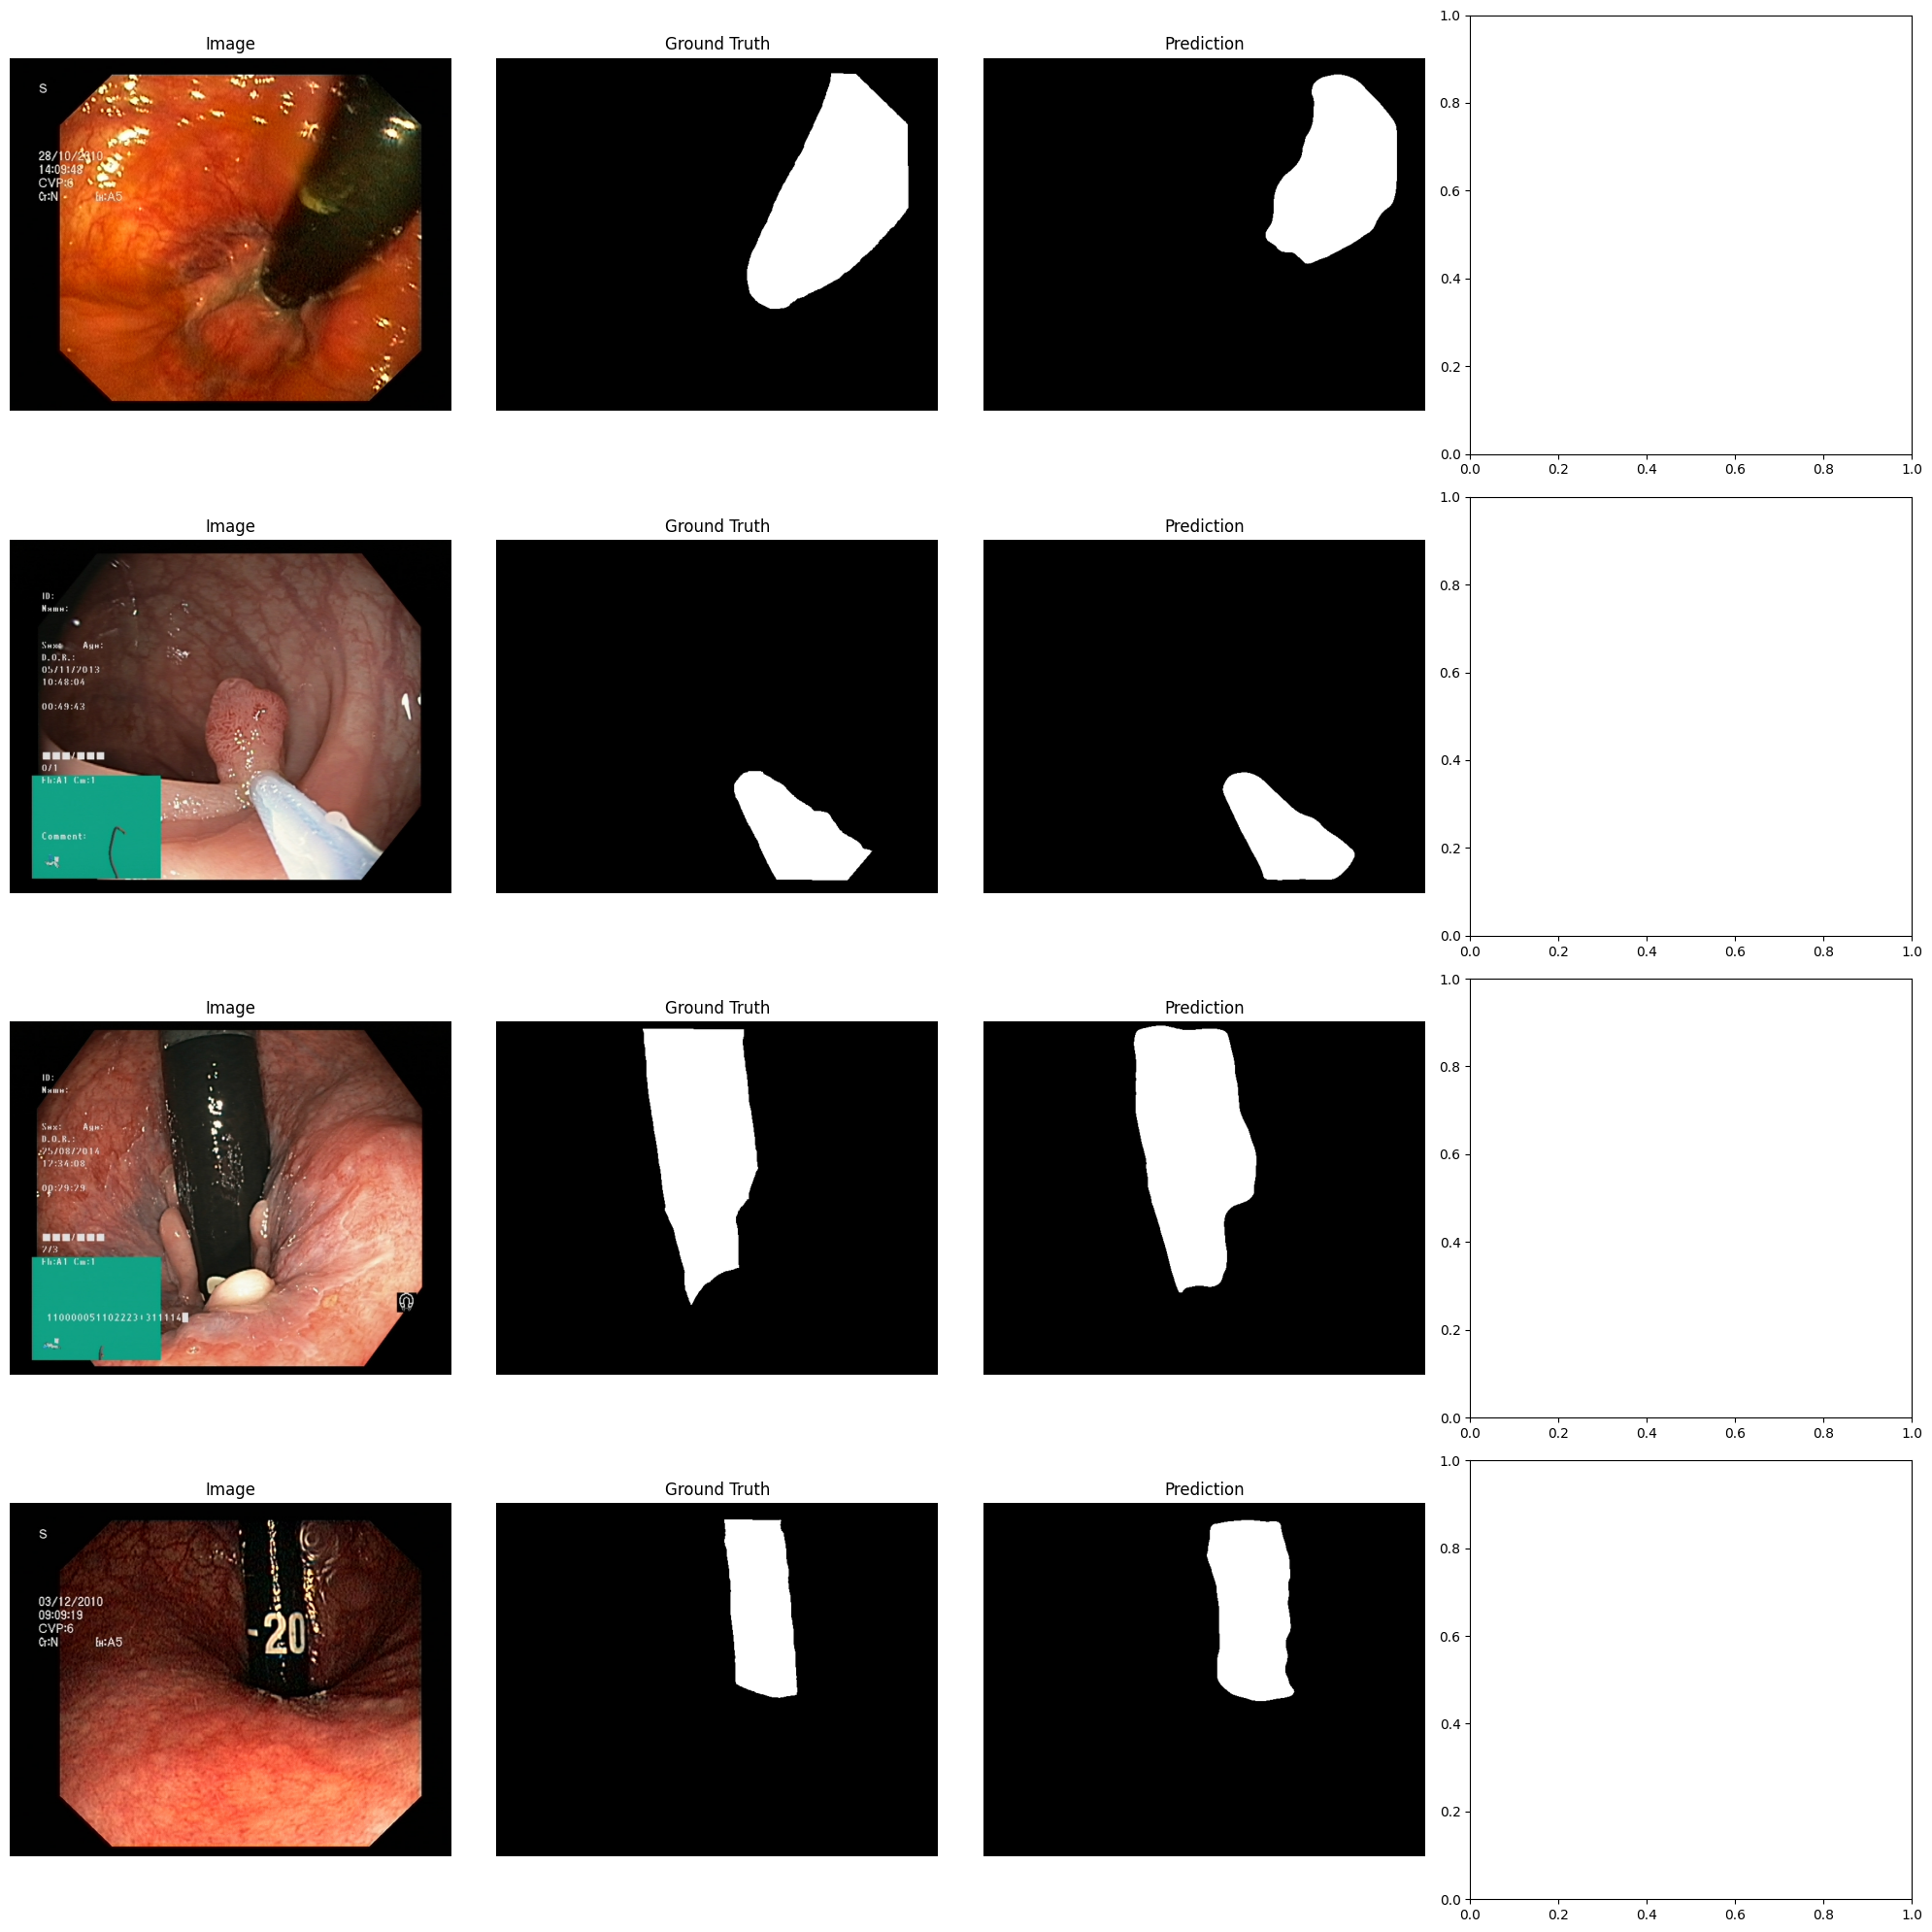


Best Results:
Best Loss       | 0.0622    
Best Accuracy   | 98.03%    
Best DSC        | 0.8883    
Best IoU        | 0.8835    


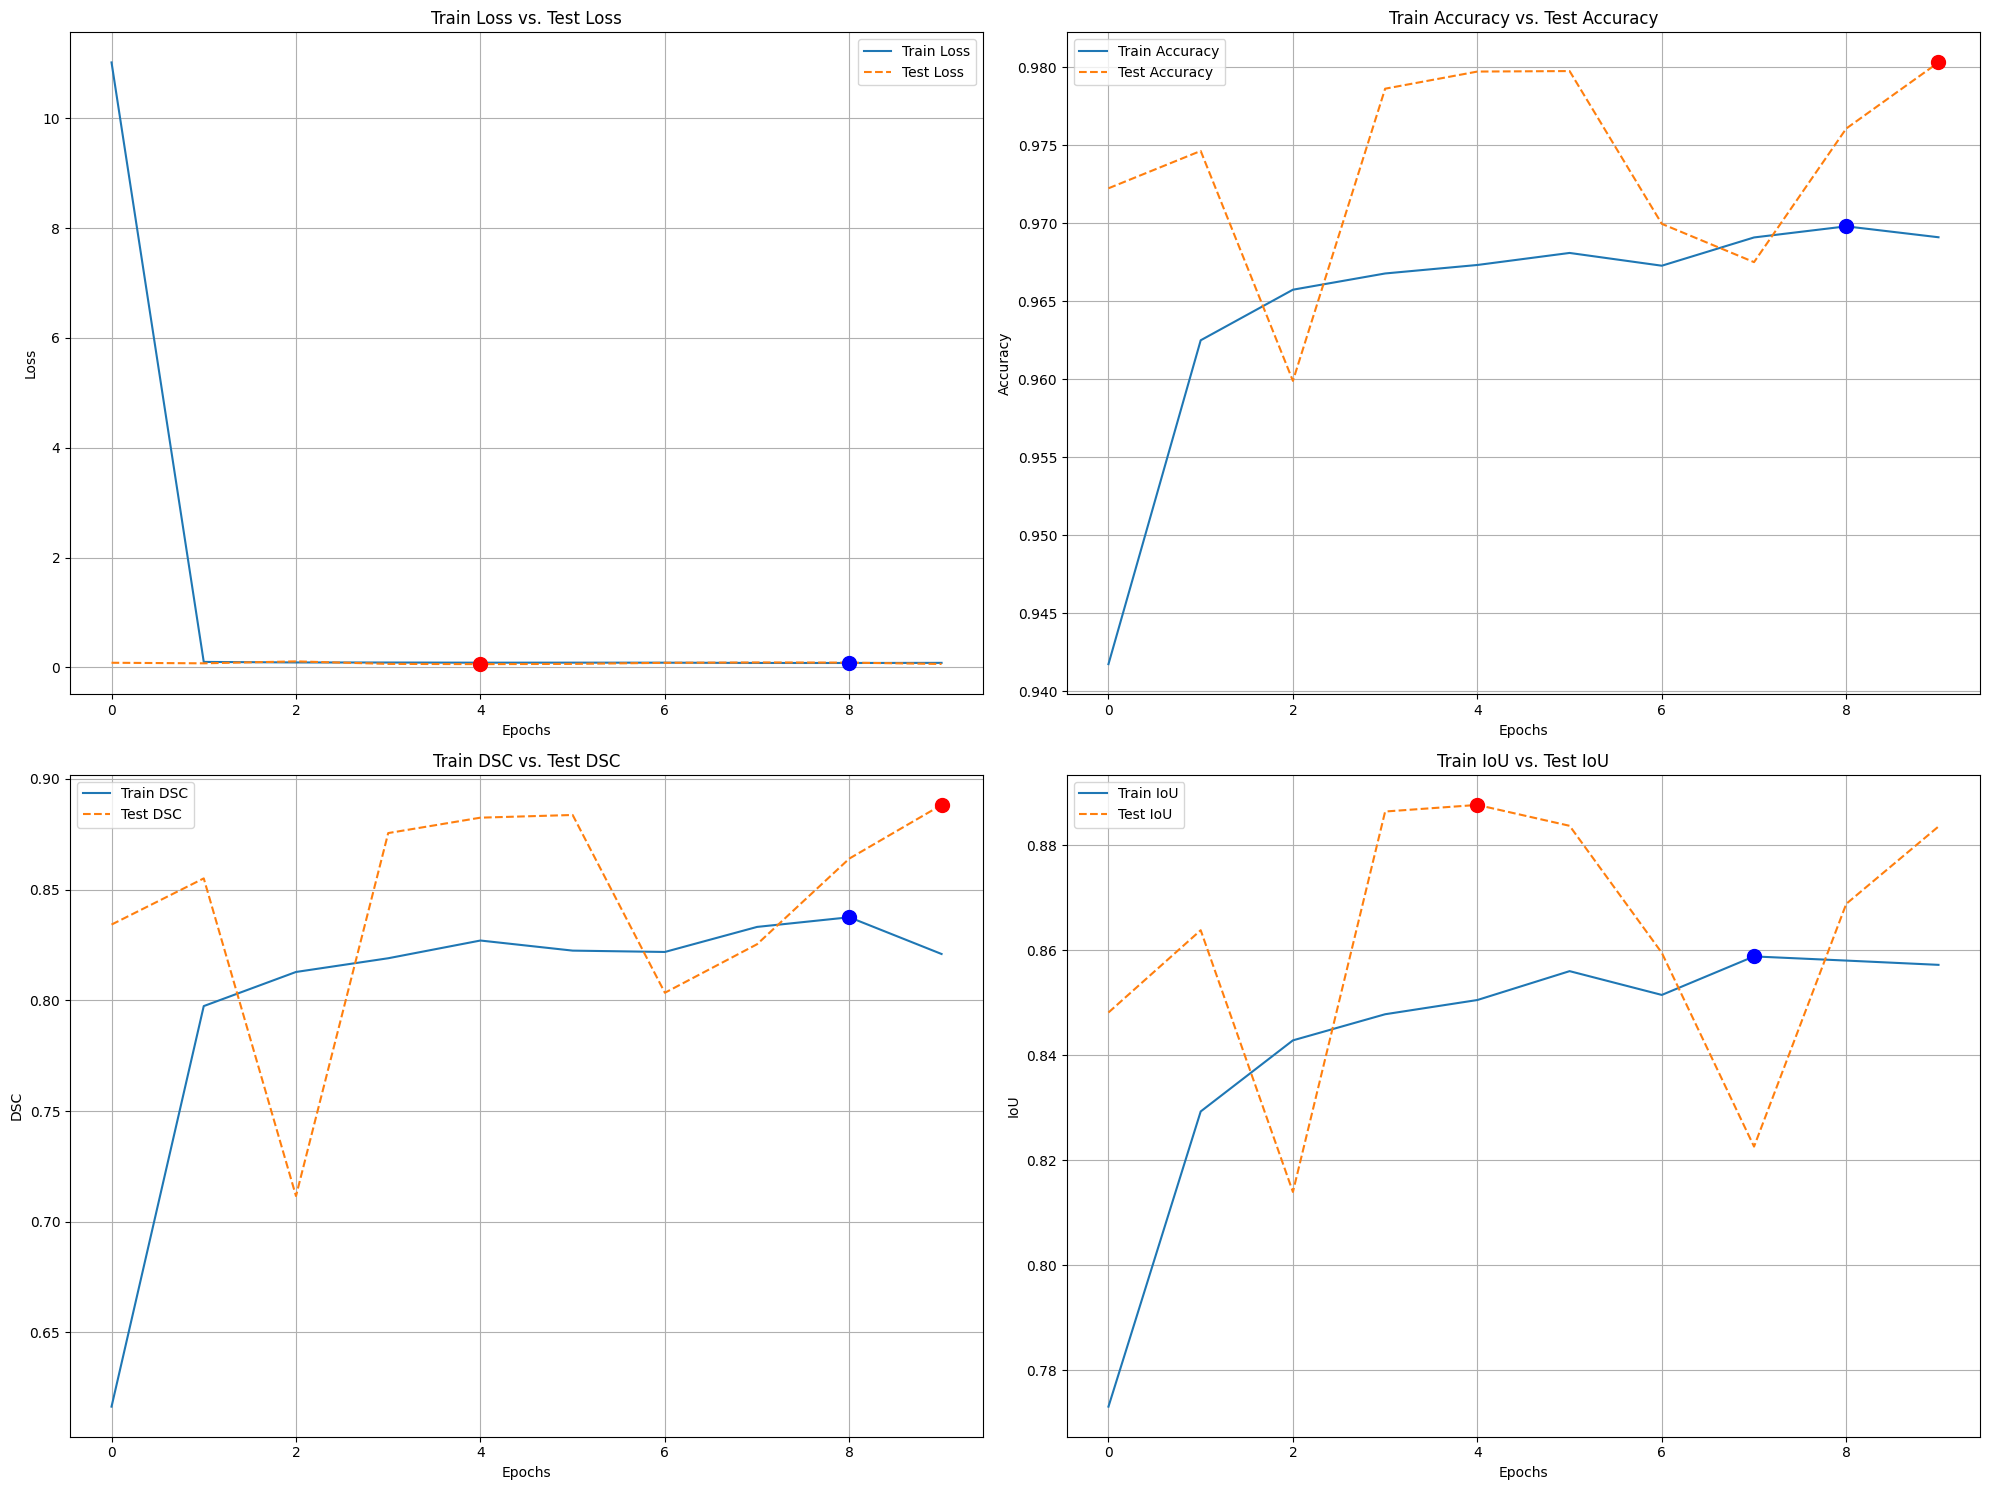

In [ ]:
# Hyperparameters
input_size = (576, 720)
out_channels = 1
batch_size = 4
best_loss = float('inf')
best_dsc = 0.0
best_iou = 0.0
best_accuracy = 0.0
visualized = False
epoch = 0

results = {}
best_results = {}

criterion = torch.nn.BCEWithLogitsLoss()
# use Learning-rate scheduler
optimizer = optim.RMSprop(model.parameters(), lr=1e-4) # can reduce the lr to 1e-4, 1e-8 ...
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
early_stopping = EarlyStopping(patience=5, verbose=True)

# Initilize the train and test storage list
train_loss_history = []
train_accuracy_history = []
test_accuracy_history = []
train_dsc_history = []
test_dsc_history = []
train_iou_history = []
test_iou_history = []
test_loss_history = []

while not early_stopping.early_stop:
  # use different learning rates to train the model
  train_loss, train_accuracy, train_dsc_val, train_iou_val = train(train_loader, model, criterion, optimizer, device)
  test_loss, test_accuracy, test_dsc_val, test_iou_val = test(test_loader, model, criterion, device)

  # Append to the lists
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  train_accuracy_history.append(train_accuracy)
  test_accuracy_history.append(test_accuracy)
  train_dsc_history.append(train_dsc_val)
  test_dsc_history.append(test_dsc_val)
  train_iou_history.append(train_iou_val)
  test_iou_history.append(test_iou_val)

  early_stopping(test_loss, test_accuracy, test_dsc_val, test_iou_val, model)
  if early_stopping.early_stop:
    print('Early stopping')
    break
  scheduler.step()
  epoch += 1

  print(f"Epoch {epoch} => "
        f"Training Loss: {train_loss:.4f} - "
        f"Training Accuracy: {train_accuracy*100:.2f}% - "
        f"Test Loss: {test_loss:.4f} - "
        f"Test Accuracy: {test_accuracy*100:.2f}% - "
        f"Training DSC: {train_dsc_val:.4f} - "
        f"Test DSC: {test_dsc_val:.4f} - "
        f"Training IoU: {train_iou_val:.4f} - "
        f"Test IoU: {test_iou_val:.4f}")

results = {
    'train_loss_history': train_loss_history,
    'test_loss_history': test_loss_history,
    'train_accuracy_history': train_accuracy_history,
    'test_accuracy_history': test_accuracy_history,
    'train_dsc_history': train_dsc_history,
    'test_dsc_history': test_dsc_history,
    'train_iou_history': train_iou_history,
    'test_iou_history': test_iou_history
     }

# Evaluate the performance of the model on the test dataset
test_results = test(test_loader, model, criterion, device)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_dsc_val = test_results[2]
test_iou_val = test_results[3]  # Assuming IoU is the fourth value in your test results
if test_iou_val > best_iou:
  best_loss = test_results[0]  # Assuming loss is the first value in your test results
  best_accuracy = test_accuracy
  best_dsc = test_dsc_val
  best_iou = test_iou_val
  print(f"The best check point is => Best Loss: {best_loss:.4f}, Best Accuracy: {best_accuracy*100:.2f}%, Best DSC: {best_dsc:.4f}, Best IoU_score: {best_iou:.4f}")

  best_results = {
      'Best Loss': best_loss,
      'Best Accuracy': best_accuracy,
      'Best DSC': best_dsc,
      'Best IoU': best_iou
  }


  best_images_dict = {}
  best_ground_truths_dict = {}
  best_predictions_dict = {}


# Load the best checkpoint for the current activation function
best_checkpoint = torch.load("best_checkpoint.pt", map_location='cuda:0')
best_loss = best_checkpoint['loss']
best_accuracy = best_checkpoint['accuracy']
best_dsc = best_checkpoint['DSC']
best_iou = best_checkpoint['IoU_score']
# Load the best model
model.load_state_dict(best_checkpoint['model_state_dict'])

with torch.no_grad():
  best_images, best_ground_truths = next(iter(test_loader))
  best_images, best_ground_truths = best_images.to(device), best_ground_truths.to(device)
  outputs = model(best_images)
  predictions = torch.sigmoid(outputs) > 0.5

  # Store the results for each activation function
  best_images_dict = best_images
  best_ground_truths_dict = best_ground_truths
  best_predictions_dict = predictions


# Now, create a list or dictionary of predictions to pass to the visualization
predictions_list = [best_predictions_dict]
# Call the visualization function
visualize_comparisons(best_images, best_ground_truths, predictions_list, device=device)

  # Print the best results in a table format
print('\nBest Results:')

for key, value in best_results.items():
    if key == 'Best Accuracy':
        print("{:<15} | {:<10.2%}".format(key, value))
    else:
        print("{:<15} | {:<10.4f}".format(key, value))

# Visualization
plt.figure(figsize=(20, 15))

# Train Loss vs. Test Loss
plt.subplot(2,2,1)
for key, data in results.items():
    if 'test_loss_history' in key:
        # Plot test loss with dashed line
        plt.plot(data, '--', label=f'Test Loss')
        best_test_loss_idx = np.argmin(data)
        best_test_loss = data[best_test_loss_idx]
        plt.scatter(best_test_loss_idx, best_test_loss, color='red', s=100, zorder=5)
    elif 'train_loss_history' in key:
        # Plot train loss
        plt.plot(data, label=f'Train Loss')
        best_train_loss_idx = np.argmin(data)
        best_train_loss = data[best_train_loss_idx]
        plt.scatter(best_train_loss_idx, best_train_loss, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss vs. Test Loss')
plt.legend()
plt.grid()

# Train Accuracy vs. Test Accuracy
plt.subplot(2,2,2)
for key, data in results.items():
    if 'test_accuracy_history' in key:
        # Plot test accuracy with dashed line
        plt.plot(data, '--', label=f'Test Accuracy')
        best_test_acc_idx = np.argmax(data)
        best_test_acc = data[best_test_acc_idx]
        plt.scatter(best_test_acc_idx, best_test_acc, color='red', s=100, zorder=5)
    elif 'train_accuracy_history' in key:
        # Plot train accuracy
        plt.plot(data, label=f'Train Accuracy')
        best_train_acc_idx = np.argmax(data)
        best_train_acc = data[best_train_acc_idx]
        plt.scatter(best_train_acc_idx, best_train_acc, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Accuracy vs. Test Accuracy')
plt.legend()
plt.grid()

# Train DSC vs. Test DSC
plt.subplot(2,2,3)
for key, data in results.items():
    if 'test_dsc_history' in key:
        # Plot test DSC with dashed line
        plt.plot(data, '--', label=f'Test DSC')
        best_test_dsc_idx = np.argmax(data)
        best_test_dsc = data[best_test_dsc_idx]
        plt.scatter(best_test_dsc_idx, best_test_dsc, color='red', s=100, zorder=5)
    elif 'train_dsc_history' in key:
        # Plot train DSC
        plt.plot(data, label=f'Train DSC')
        best_train_dsc_idx = np.argmax(data)
        best_train_dsc = data[best_train_dsc_idx]
        plt.scatter(best_train_dsc_idx, best_train_dsc, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('DSC')
plt.title('Train DSC vs. Test DSC')
plt.legend()
plt.grid()

# Train IoU vs. Test IoU
plt.subplot(2,2,4)
for key, data in results.items():
    if 'test_iou_history' in key:
        # Plot test IoU with dashed line
        plt.plot(data, '--', label=f'Test IoU')
        best_test_iou_idx = np.argmax(data)
        best_test_iou = data[best_test_iou_idx]
        plt.scatter(best_test_iou_idx, best_test_iou, color='red', s=100, zorder=5)
    elif 'train_iou_history' in key:
        # Plot train IoU
        plt.plot(data, label=f'Train IoU')
        best_train_iou_idx = np.argmax(data)
        best_train_iou = data[best_train_iou_idx]
        plt.scatter(best_train_iou_idx, best_train_iou, color='blue', s=100, zorder=5)

plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.title('Train IoU vs. Test IoU')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
